# Imports

In [3]:
from lifelines import KaplanMeierFitter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from IPython.display import HTML, display
from sklearn.model_selection import KFold
import pickle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

import joblib


In [ ]:
#!unzip "C:\Users\Rewan\Downloads\archive.zip"

'unzip' is not recognized as an internal or external command,
operable program or batch file.


# Data Structure and project Summary

The goal of this project is to predict Customer Churn for Telecom Company.

Take a glimpse of our dataset below

In [ ]:
df_schema = pd.read_csv('/content/telecom_data_dictionary.csv', encoding='latin-1')
df_schema


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 3-4: truncated \UXXXXXXXX escape (447271365.py, line 1)

# Intial EDA

In [4]:
telecom_churn_df = pd.read_csv('/content/telecom_customer_churn.csv')
telecom_zipcode_df = pd.read_csv('/content/telecom_zipcode_population.csv')

In [5]:
telecom_merged_df = pd.merge(telecom_churn_df, telecom_zipcode_df, on='Zip Code', how='left')

## vals of each attribute

In [6]:
telecom_merged_df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason,Population
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN,4498
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN,31297
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices,62069
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction,46677
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability,42853


In [7]:
categorical_cols = telecom_merged_df.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols.drop(['Customer ID', 'City'])

display(HTML(f'<h2>Categorical Features</h2>'))
for col in categorical_cols:
    unique_vals = telecom_merged_df[col].unique()
    display(HTML(f'<h3>Unique Values of {col}</h3>'))
    display(HTML(pd.DataFrame({col: unique_vals}).to_html()))


,Gender
0,Female
1,Male


,Married
0,Yes
1,No


,Offer
0,NaN
1,Offer E
2,Offer D
3,Offer A
4,Offer B
5,Offer C


,Phone Service
0,Yes
1,No


,Multiple Lines
0,No
1,Yes
2,NaN


,Internet Service
0,Yes
1,No


,Internet Type
0,Cable
1,Fiber Optic
2,DSL
3,NaN


,Online Security
0,No
1,Yes
2,NaN


,Online Backup
0,Yes
1,No
2,NaN


,Device Protection Plan
0,No
1,Yes
2,NaN


,Premium Tech Support
0,Yes
1,No
2,NaN


,Streaming TV
0,Yes
1,No
2,NaN


,Streaming Movies
0,No
1,Yes
2,NaN


,Streaming Music
0,No
1,Yes
2,NaN


,Unlimited Data
0,Yes
1,No
2,NaN


,Contract
0,One Year
1,Month-to-Month
2,Two Year


,Paperless Billing
0,Yes
1,No


,Payment Method
0,Credit Card
1,Bank Withdrawal
2,Mailed Check


,Customer Status
0,Stayed
1,Churned
2,Joined


,Churn Category
0,NaN
1,Competitor
2,Dissatisfaction
3,Other
4,Price
5,Attitude


,Churn Reason
0,NaN
1,Competitor had better devices
2,Product dissatisfaction
3,Network reliability
4,Limited range of services
5,Competitor made better offer
6,Don't know
7,Long distance charges
8,Attitude of service provider
9,Attitude of support person


## shape

In [8]:
telecom_merged_df.shape

(7043, 39)

## describe

In [9]:
telecom_merged_df.describe()

,Age,Number of Dependents,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Population
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,6361.000000,5517.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,93486.070567,36.197455,-119.756684,1.951867,32.386767,25.420517,26.189958,63.596131,2280.381264,1.962182,6.860713,749.099262,3034.379056,22139.603294
std,16.750352,0.962802,1856.767505,2.468929,2.154425,3.001199,24.542061,14.200374,19.586585,31.204743,2266.220462,7.902614,25.104978,846.660055,2865.204542,21152.392837
min,19.000000,0.000000,90001.000000,32.555828,-124.301372,0.000000,1.000000,1.010000,2.000000,-10.000000,18.800000,0.000000,0.000000,0.000000,21.360000,11.000000
25%,32.000000,0.000000,92101.000000,33.990646,-121.788090,0.000000,9.000000,13.050000,13.000000,30.400000,400.150000,0.000000,0.000000,70.545000,605.610000,2344.000000
50%,46.000000,0.000000,93518.000000,36.205465,-119.595293,0.000000,29.000000,25.690000,21.000000,70.050000,1394.550000,0.000000,0.000000,401.440000,2108.640000,17554.000000
75%,60.000000,0.000000,95329.000000,38.161321,-117.969795,3.000000,55.000000,37.680000,30.000000,89.750000,3786.600000,0.000000,0.000000,1191.100000,4801.145000,36125.000000
max,80.000000,9.000000,96150.000000,41.962127,-114.192901,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000,105285.000000


## info

In [10]:
telecom_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

## correlation heatmap

<ipython-input-11-09e13a7bd9a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_merged_df['Customer Status'] = telecom_merged_df['Customer Status'].apply(lambda x: 1 if x == 'Churned' else 0)


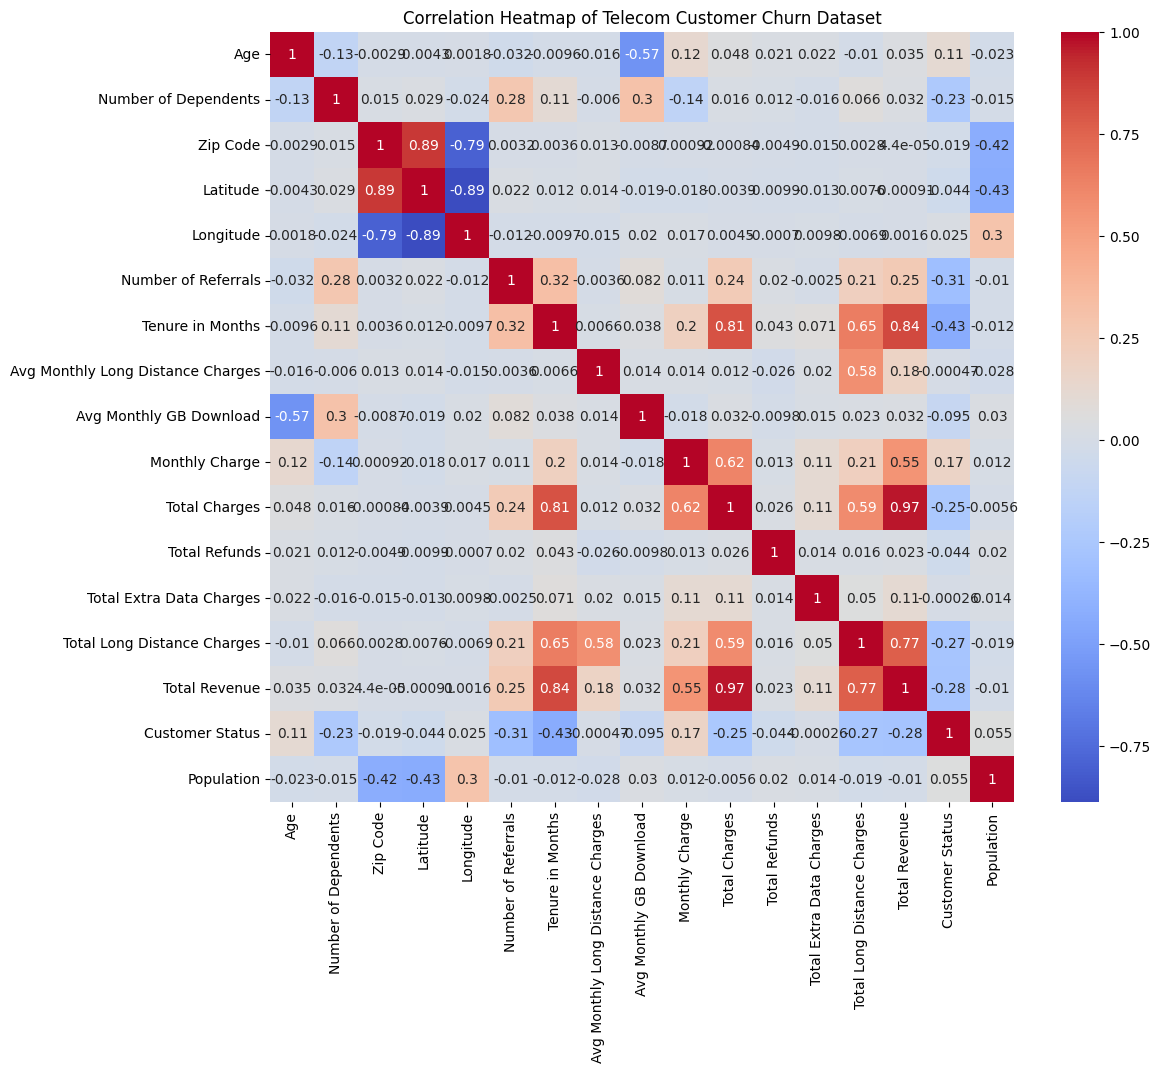

In [11]:
telecom_merged_df = telecom_merged_df[telecom_merged_df['Customer Status'] != 'Joined']
telecom_merged_df['Customer Status'] = telecom_merged_df['Customer Status'].apply(lambda x: 1 if x == 'Churned' else 0)
plt.figure(figsize=(12, 10))
sns.heatmap(telecom_merged_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Telecom Customer Churn Dataset')
plt.show()


Strongest Correlations are between Customer Status and:

Number of Dependents

Number of Referrals

Tenure in Months

Monthly Charges

Total charges

Total Long Distance Charges

#Data Cleaning

let's clean the data and then go back to answer some questions!

## impute offer

In [12]:
def fill_offer_na(df):
    df['Offer'] = df['Offer'].fillna('No Offer')
    return df

train_merged_df = fill_offer_na(telecom_merged_df)


## impute Avg Monthly Long Distance Charges and Multiple Lines according to Phone Service

they should be 0 and No Phone Service respectively if the customer don't have Home Phone Serive

In [13]:
print(train_merged_df[train_merged_df['Phone Service'] == 'No'].shape[0])
print(train_merged_df['Avg Monthly Long Distance Charges'].isnull().sum())
print(train_merged_df['Multiple Lines'].isnull().sum())

644
644
644


In [14]:
def fill_phone_service_depndents(df):
    df['Avg Monthly Long Distance Charges'] = df['Avg Monthly Long Distance Charges'].fillna(0)
    # For categorical column
    df['Multiple Lines'] = df['Multiple Lines'].fillna('No Phone Service')
    return df

train_merged_df = fill_phone_service_depndents(telecom_merged_df)

## Impute InterNet and all add-ons services

they should be 0 and No Internet if the customer doesn't have Internet Service

In [15]:
print(train_merged_df[train_merged_df['Internet Service'] == 'No'].shape[0])

1344


In [16]:
def fill_internet_add_ons(df):
    # For categorical features
    internet_cat_cols = ['Internet Type'] + ['Online Security','Online Backup',
                       'Device Protection Plan','Premium Tech Support',
                       'Streaming TV','Streaming Movies','Streaming Music',
                       'Unlimited Data']
    df[internet_cat_cols] = df[internet_cat_cols].fillna('No Internet Service')
    # For numeric feature
    df['Avg Monthly GB Download'] = df['Avg Monthly GB Download'].fillna(0)
    return df

train_merged_df = fill_internet_add_ons(telecom_merged_df)


# Advanced EDA

## Target Class Distribution

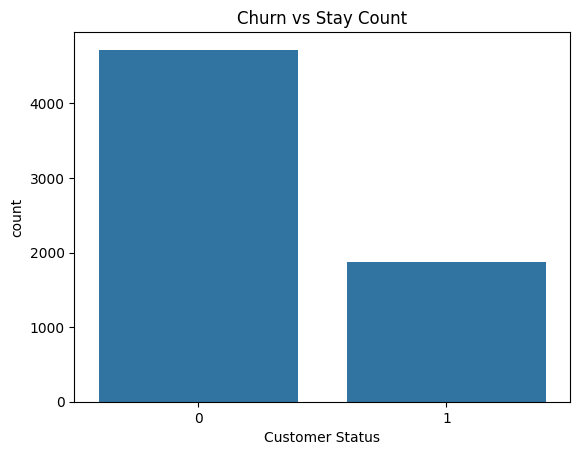

Churn rate:
 Customer Status
0    0.716345
1    0.283655
Name: proportion, dtype: float64


In [17]:
sns.countplot(x='Customer Status', data=train_merged_df)
plt.title('Churn vs Stay Count')
plt.show()

churn_rate = train_merged_df['Customer Status'].value_counts(normalize=True)
print("Churn rate:\n", churn_rate)


71% of our data is about users whom stayed while 28% about customers whom Churned.

## Analyze distributions of numerical and categorical features.

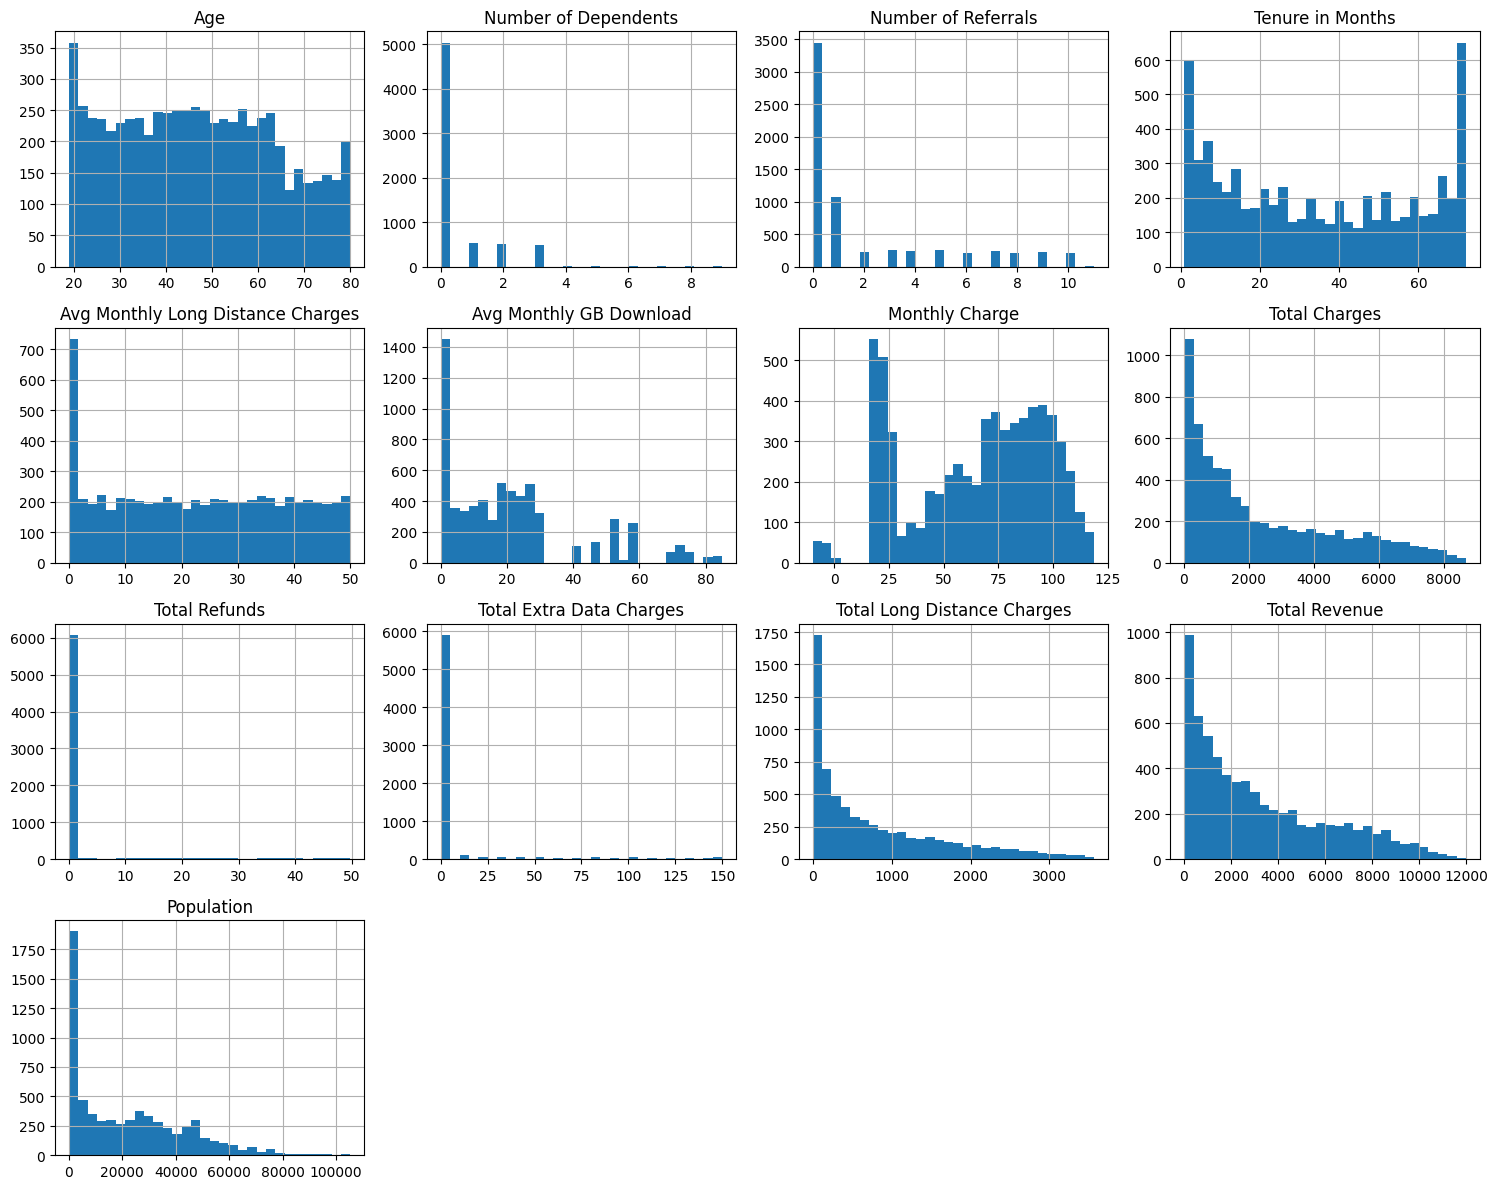

In [18]:
numeric_cols = [
    'Age', 'Number of Dependents', 'Number of Referrals',
    'Tenure in Months', 'Avg Monthly Long Distance Charges',
    'Avg Monthly GB Download', 'Monthly Charge', 'Total Charges',
    'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue', 'Population'
]

train_merged_df[numeric_cols].hist(figsize=(15, 12), bins=30)
plt.tight_layout()
plt.show()


feature: needed transformation

Tenure in Months: represnt different Segements of Customers so might consider Binning.

Avg Monthly Long Distance Charges & Avg Monthly GB Download : log transformation & scaling

Monthly Charge: Scaling

Total Refunds: encode as has_refunded.

Total Extra Data Charges:  Log transform + Scaling

Total Long Distance Charges & Total Revenue & Population	: Log transform + Scaling

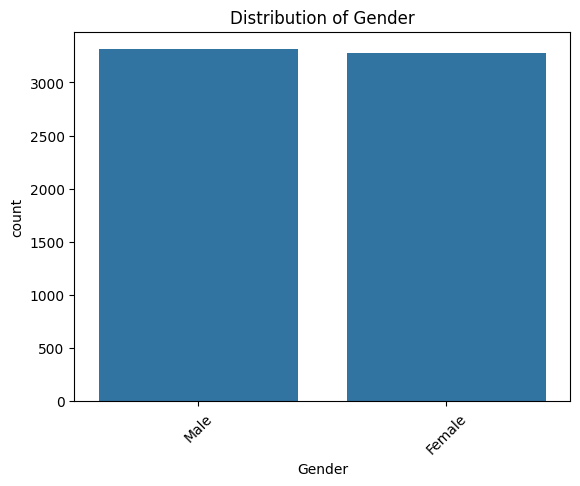

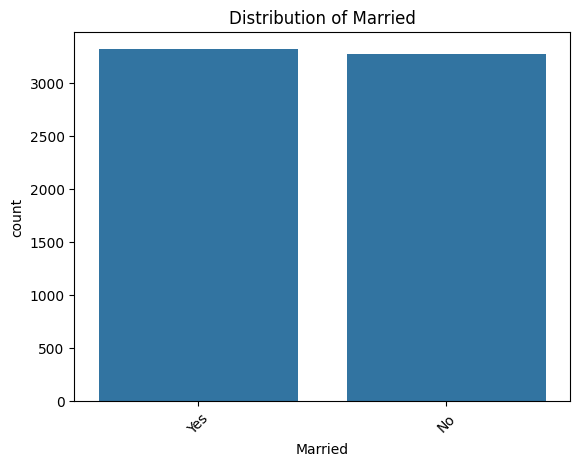

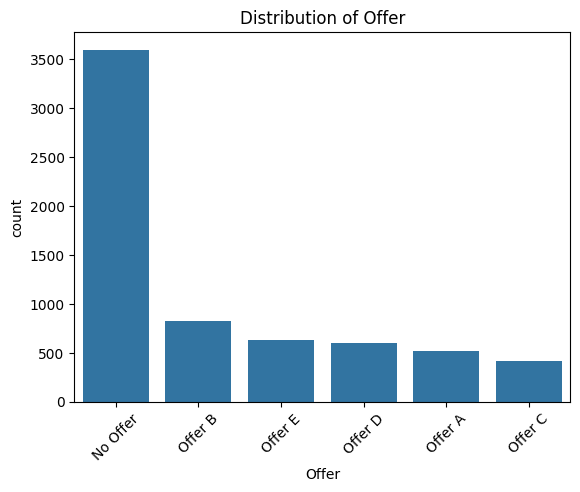

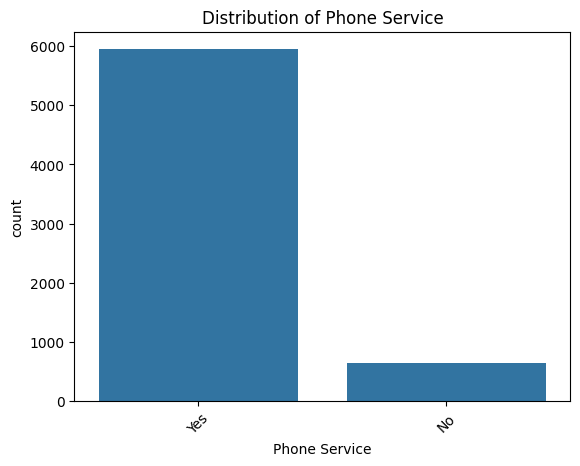

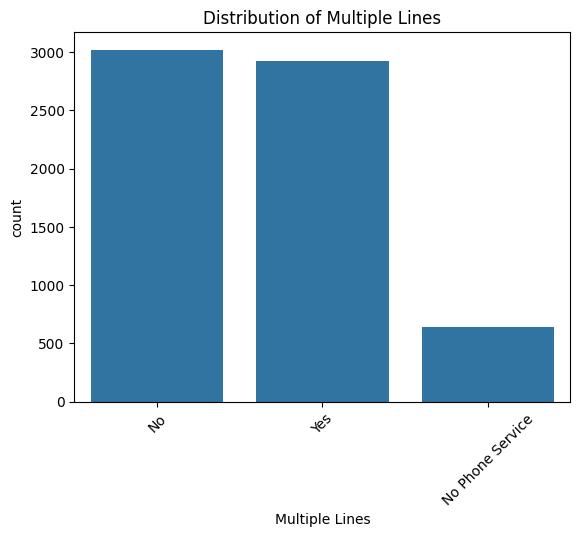

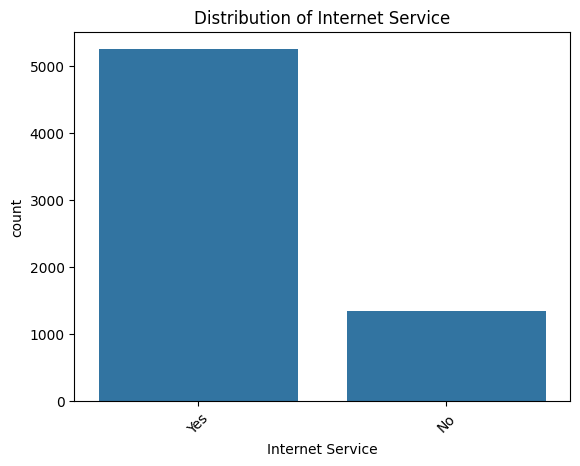

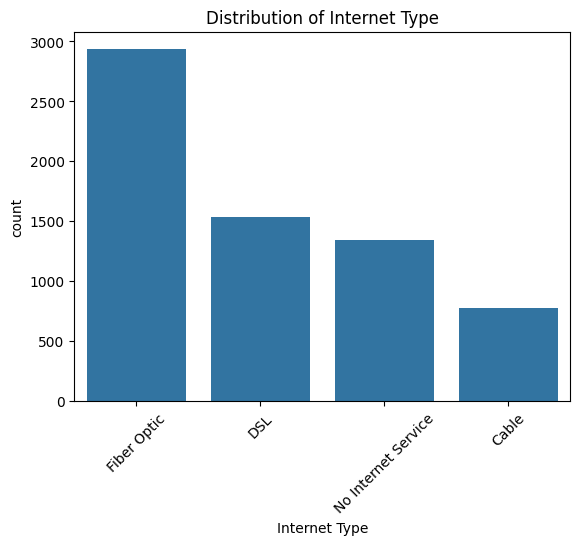

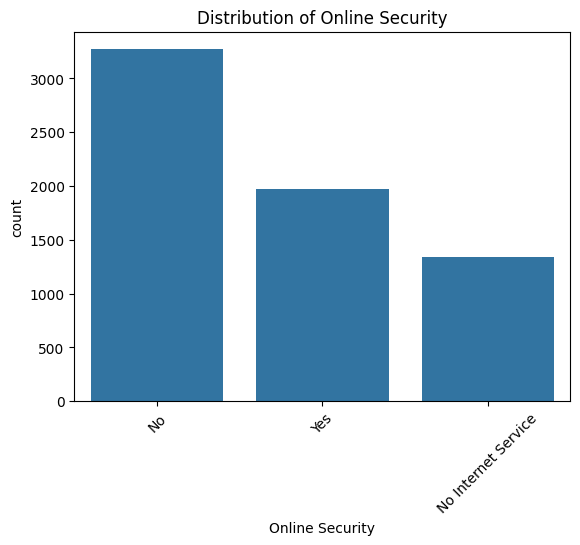

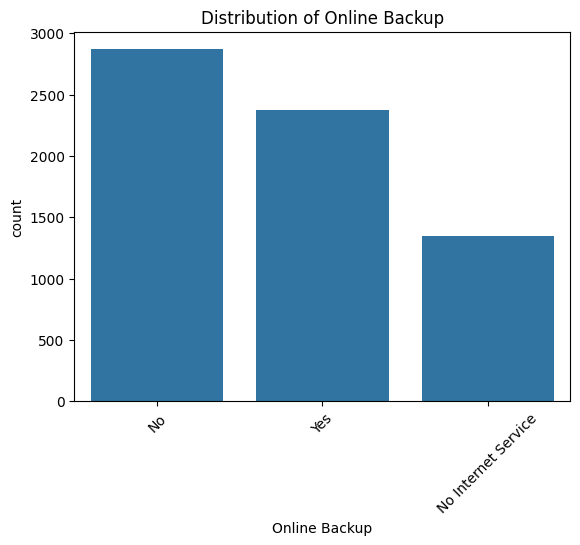

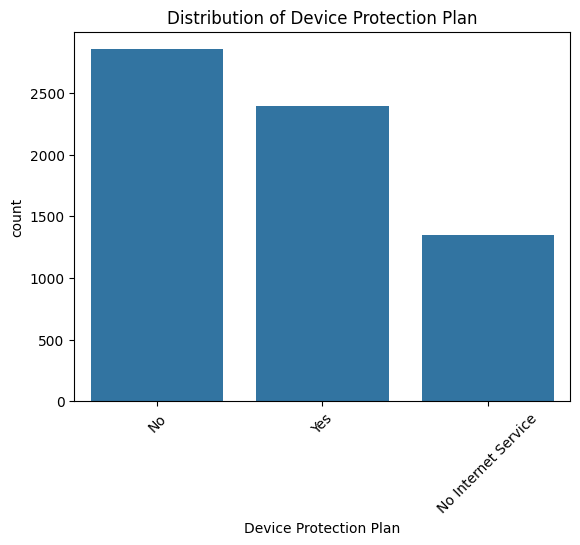

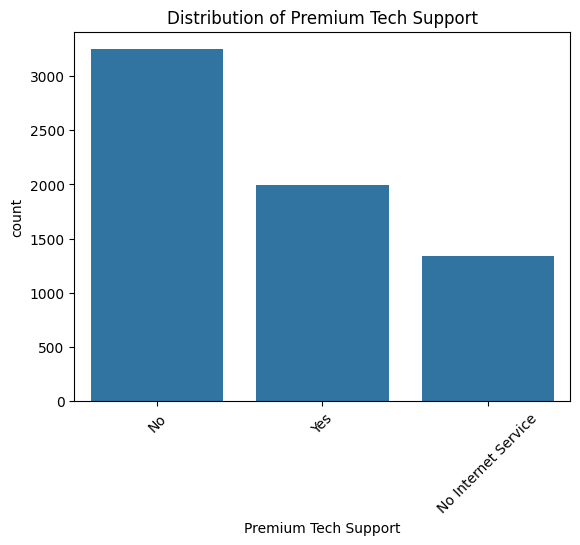

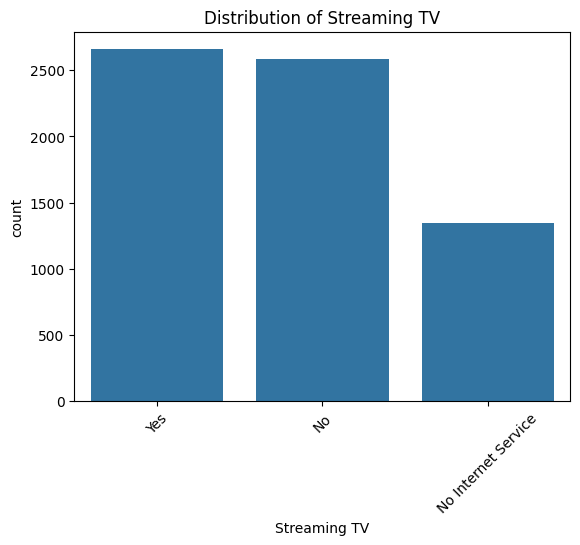

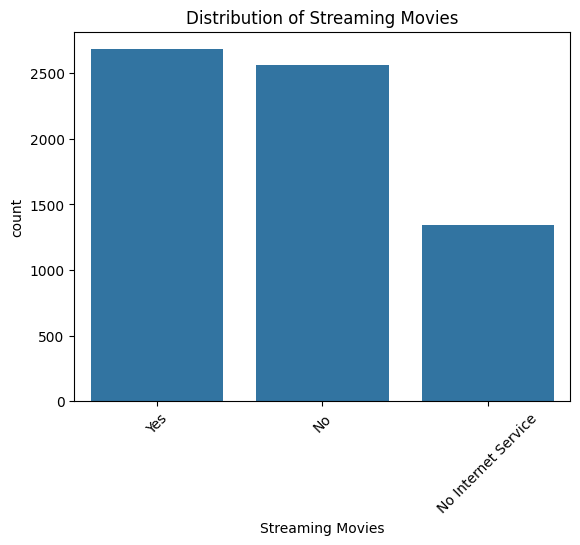

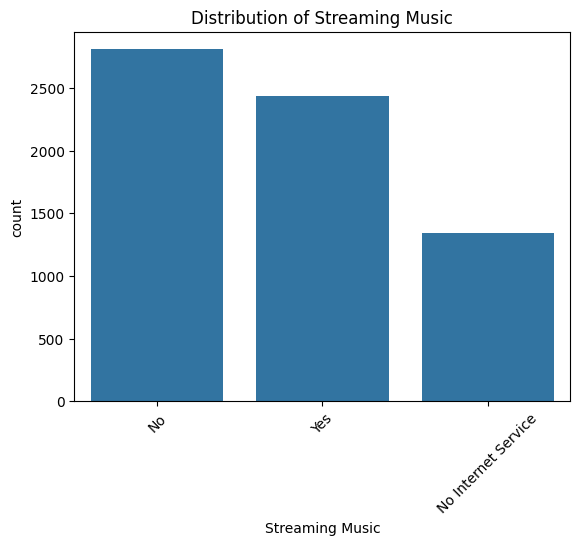

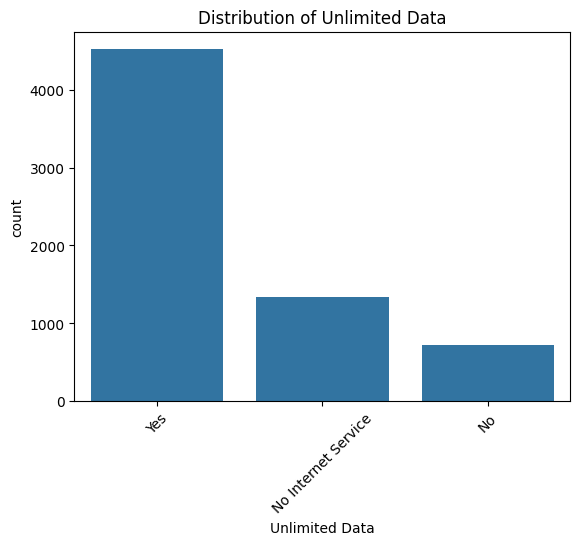

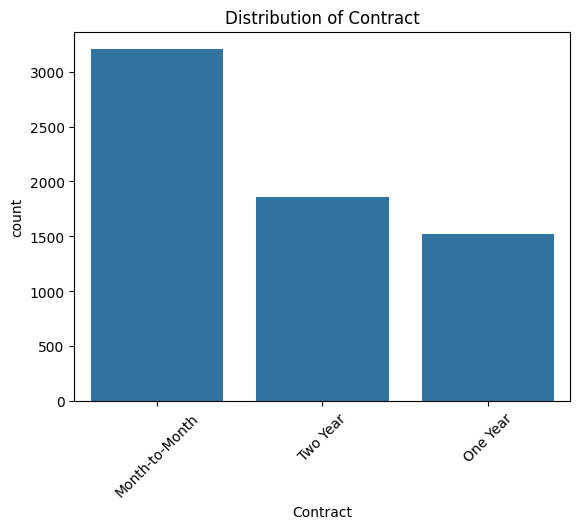

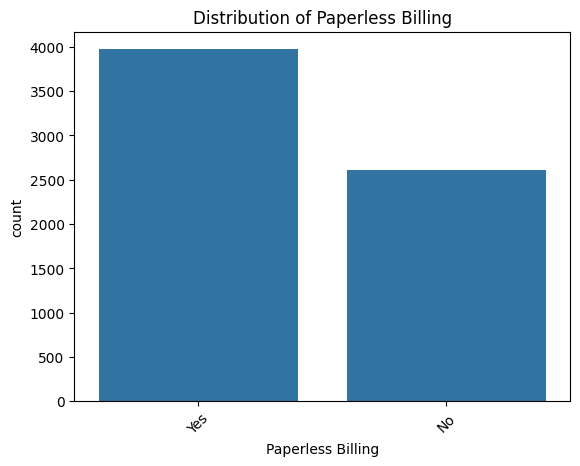

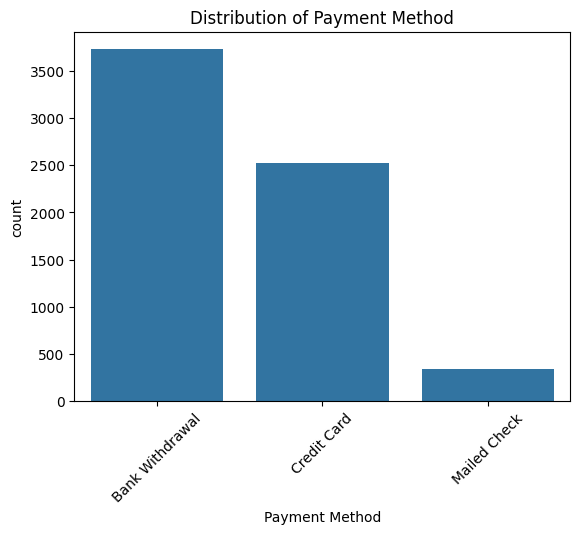

In [19]:
categorical_cols = [
    'Gender', 'Married', 'Offer', 'Phone Service', 'Multiple Lines',
    'Internet Service', 'Internet Type', 'Online Security', 'Online Backup',
    'Device Protection Plan', 'Premium Tech Support', 'Streaming TV',
    'Streaming Movies', 'Streaming Music', 'Unlimited Data',
    'Contract', 'Paperless Billing', 'Payment Method'
]

for col in categorical_cols:
    sns.countplot(data=train_merged_df, x=col, order=train_merged_df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()


Feature: Action

Gender, Married, Offer and Phone Service : One-Hot encoding

Multiple Lines & Unlimited Data: one-hot or Ordinal encoding

Internet Service and Internet Type: One-Hot encoding

Online Security, Online Backup, Device Protection Plan, Premium Tech Support, Streaming TV, Streaming Movies, Streaming Music: one-Hot encoding

Contract & Payment Method: Ordinal

Paperless Billing: one-hot encoding



## Bivariate Analysis with Target

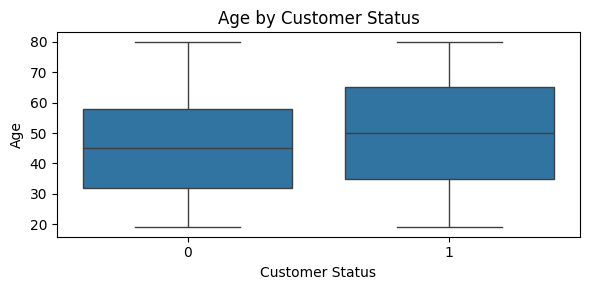

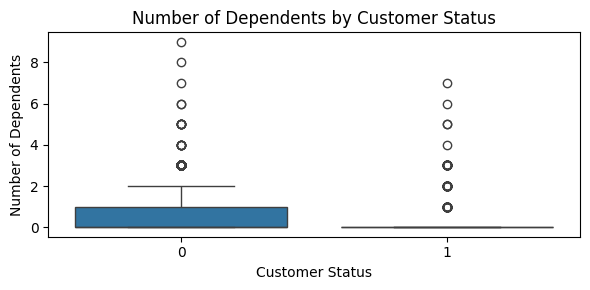

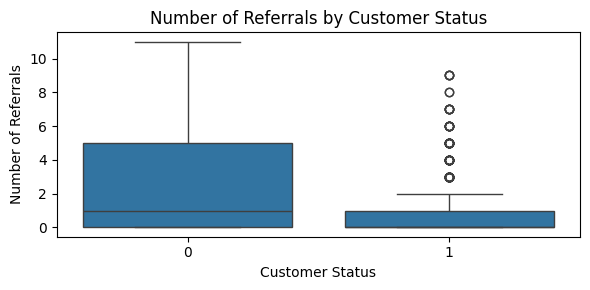

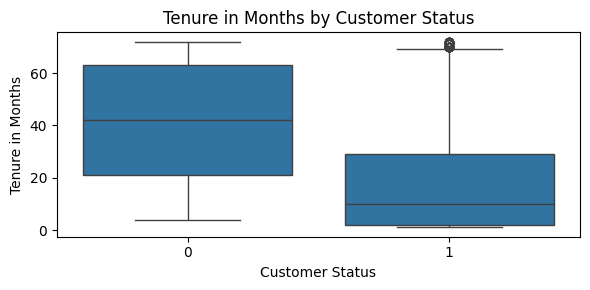

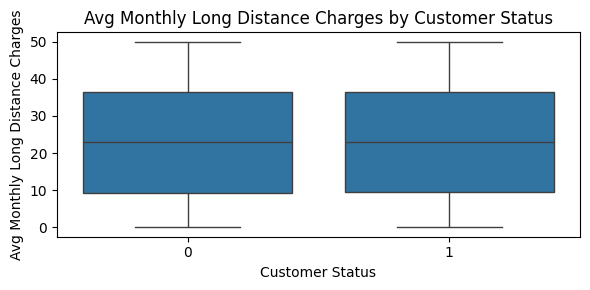

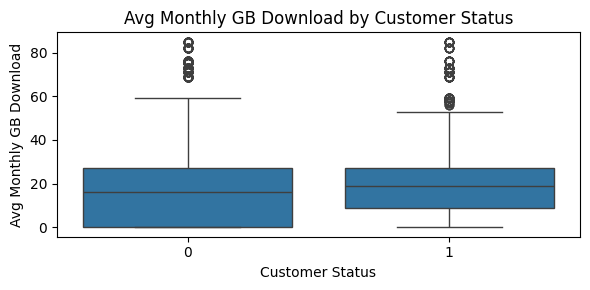

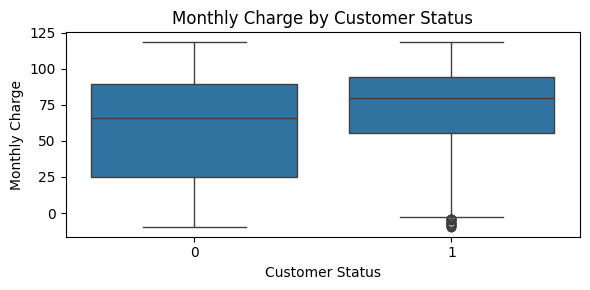

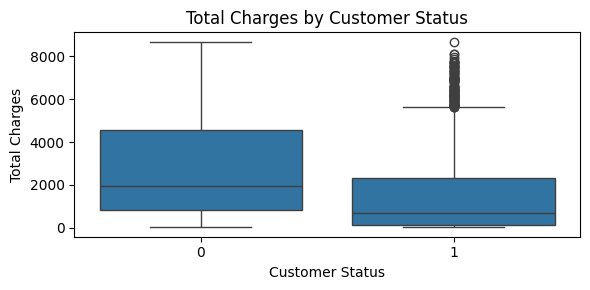

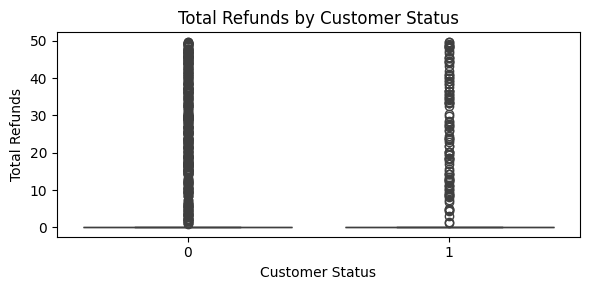

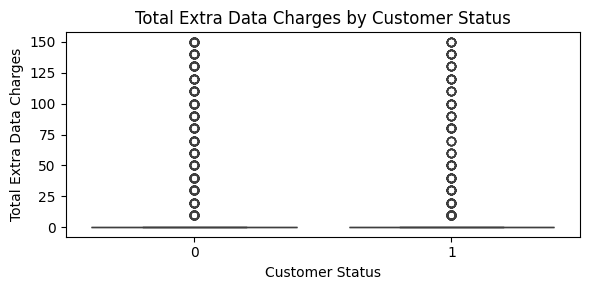

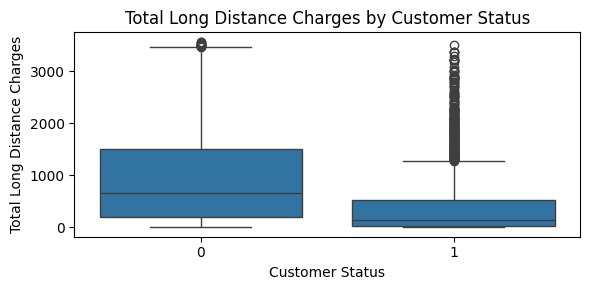

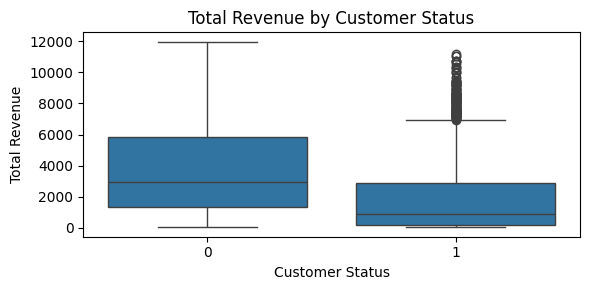

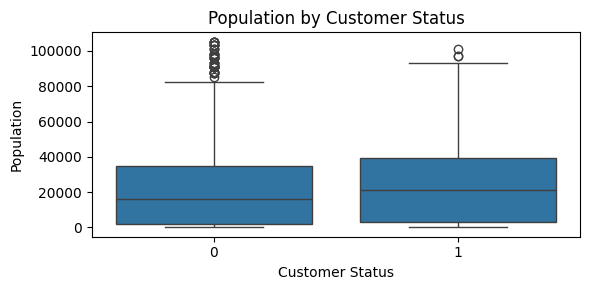

In [20]:
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x='Customer Status', y=col, data=train_merged_df)
    plt.title(f'{col} by Customer Status')
    plt.tight_layout()
    plt.show()


Customers whom has more dependents and made more referrals tends to stay more.

Customers whom stay more are less likely to churn. -there's still some outliers whom churned after long periodwith us.-

Customers whom pay more monthly tends to churn more.

Customers whom have high total charges tends to churn less and this correlates with tenure in months.

Total Refunds and Total Extra Data Charges might be converted to binary features.

Customers with more Total Long Distance Charges and more Total Revenue tends to stay more but i think this one also correlates with Tenure in Months.

Population is a bit near each other but Higher populations comes with more churns. this maybe relates for high competition there or something.

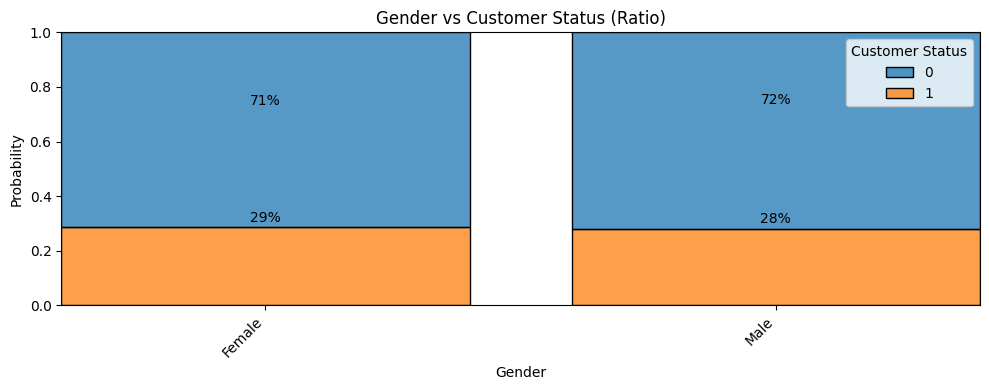

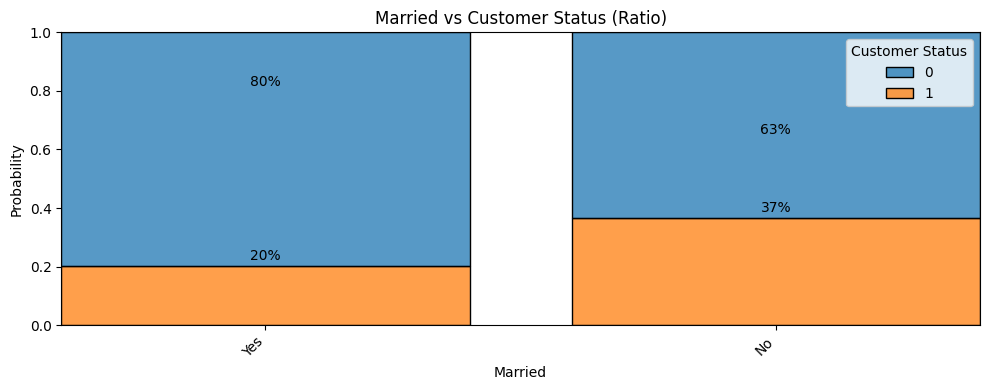

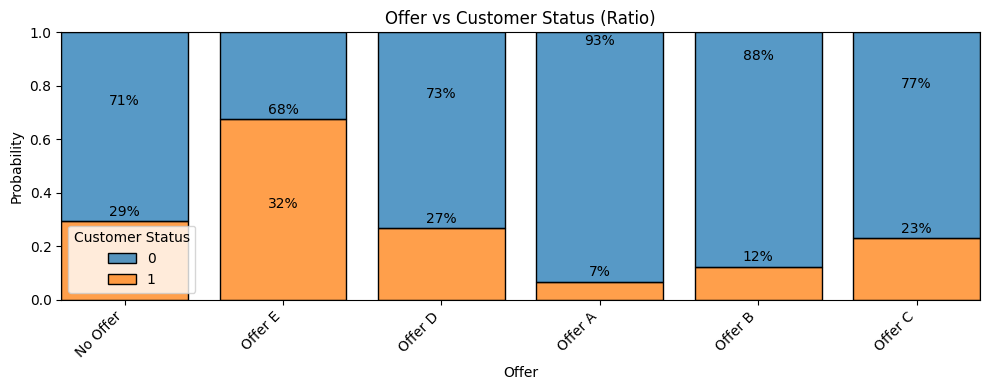

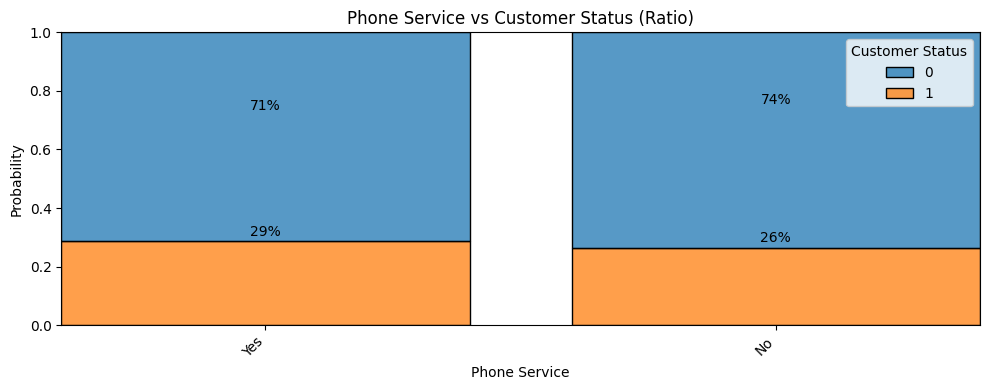

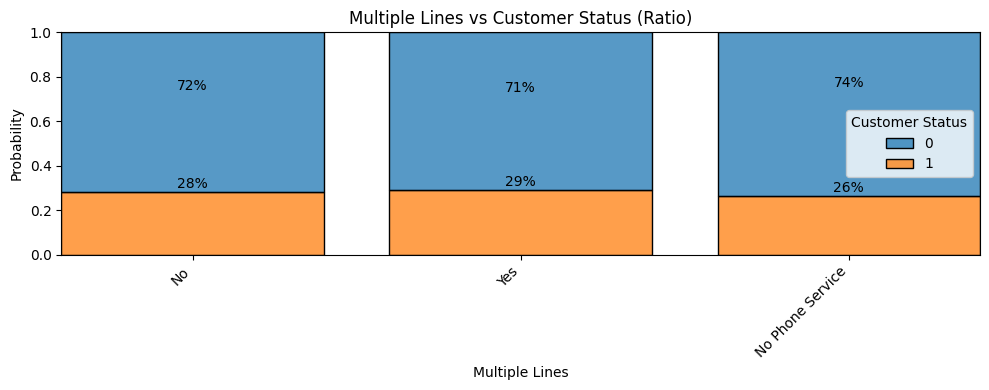

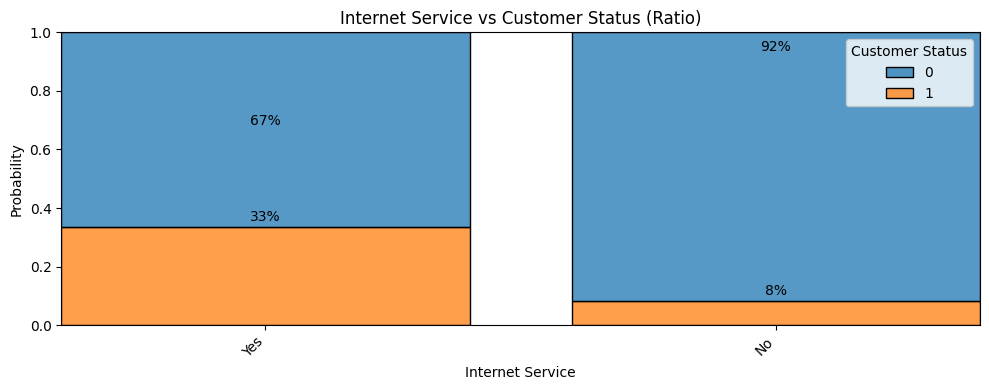

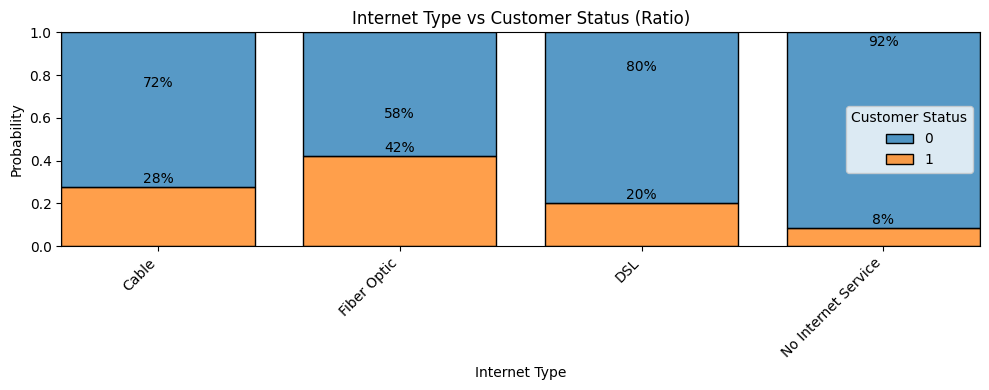

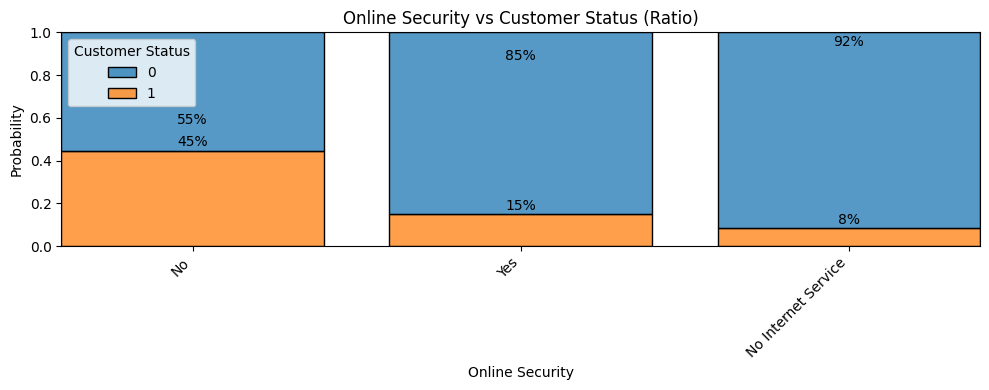

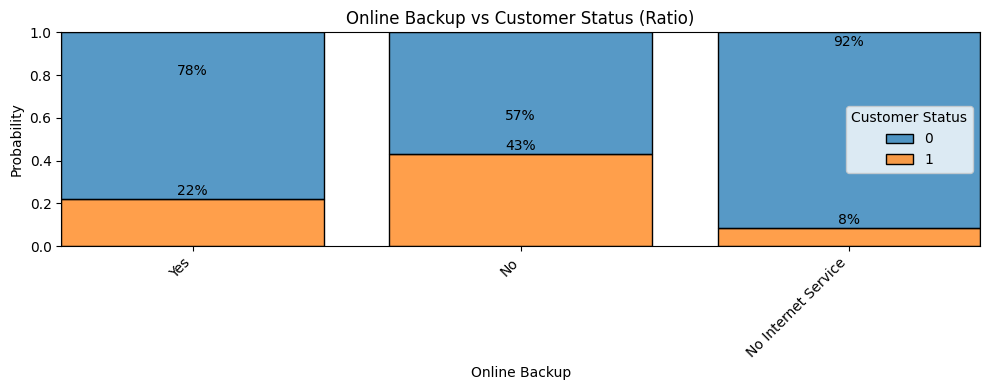

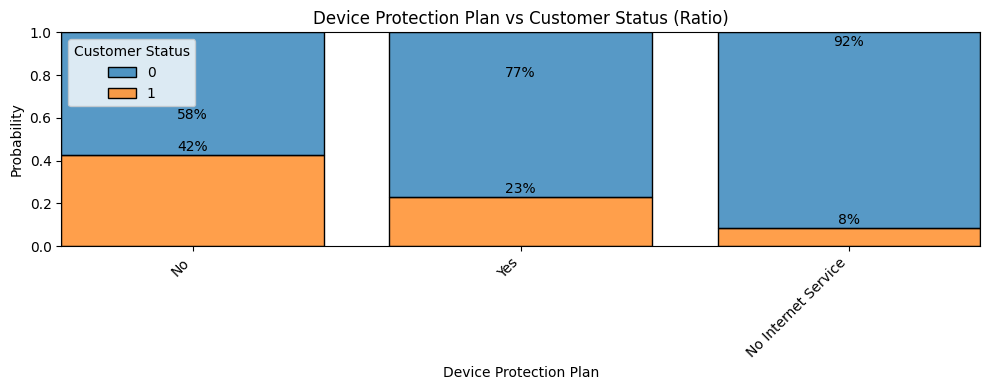

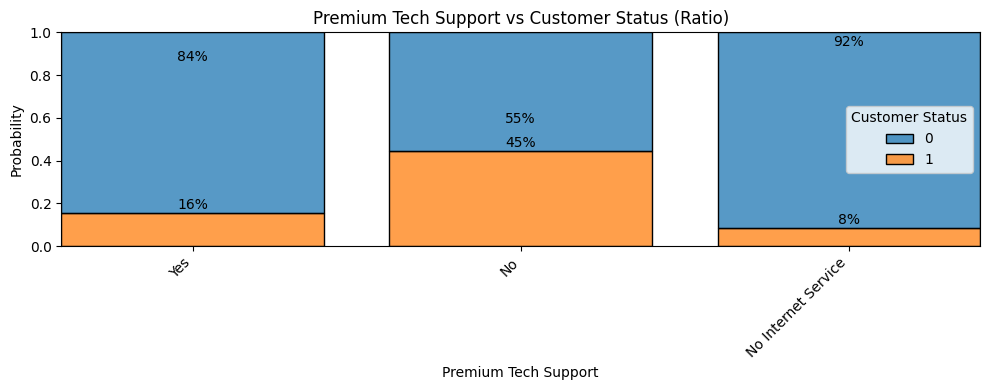

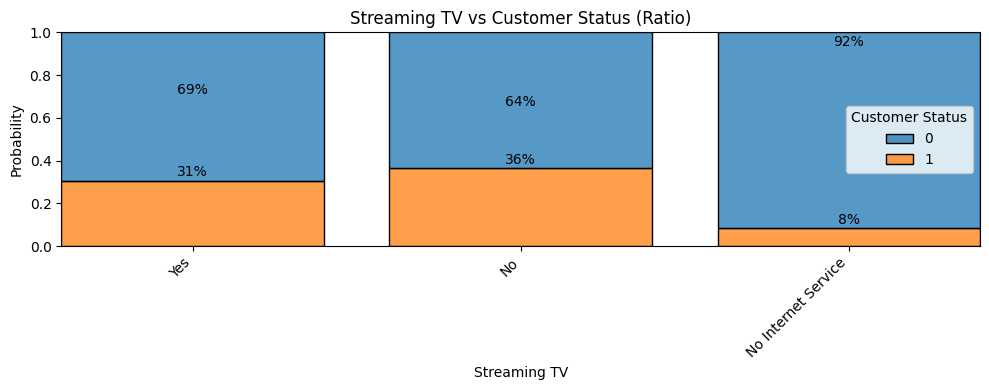

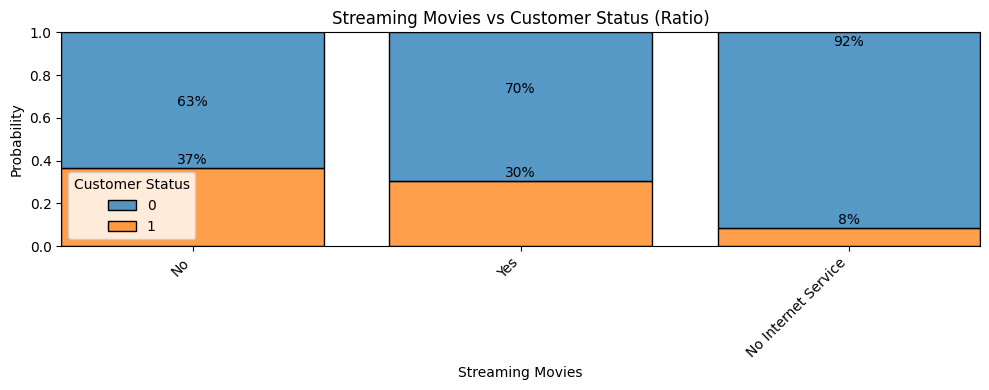

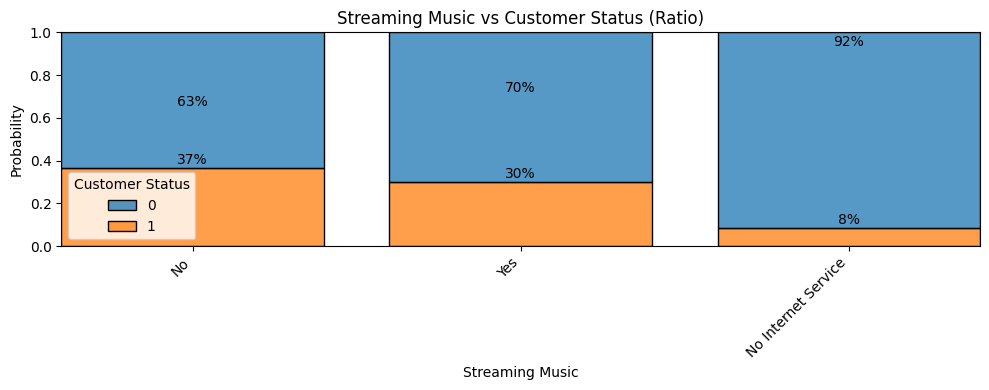

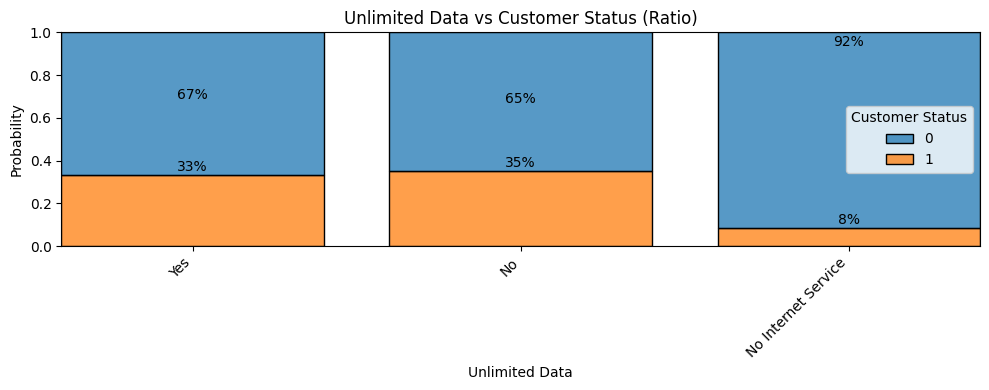

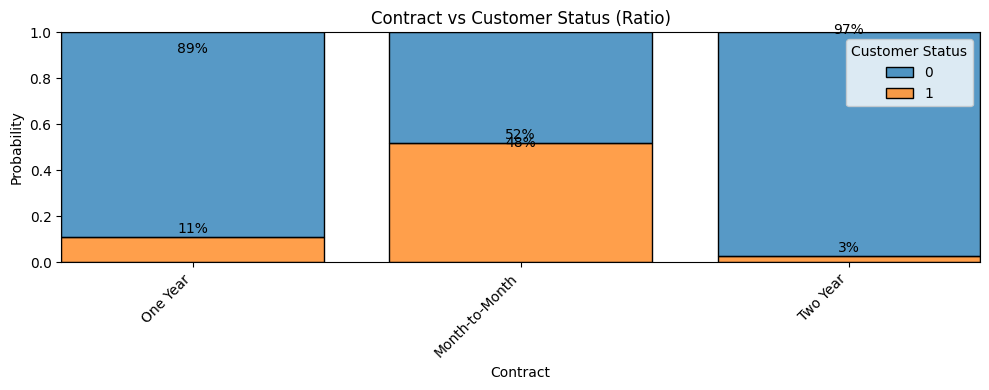

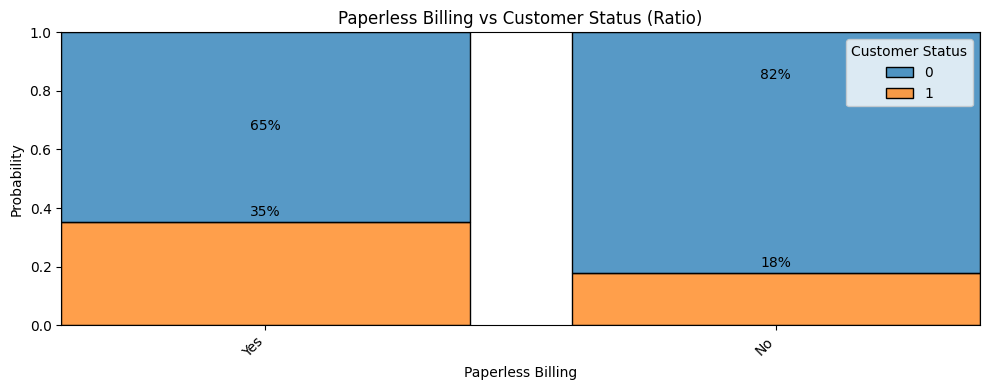

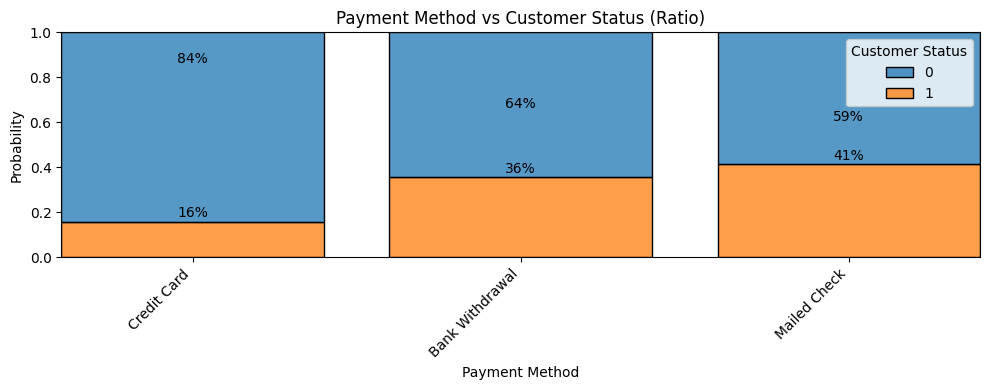

In [21]:
for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    ax = sns.histplot(data=train_merged_df,
                       x=col,
                       hue='Customer Status',
                       stat="probability",  # Display as probability (ratio)
                       multiple="fill",  # Stack probabilities
                       shrink=.8)

    plt.title(f'{col} vs Customer Status (Ratio)')
    plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis labels
    plt.ylabel("Probability")
    plt.tight_layout()

    # Annotate with percentages on top of bars
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Avoid annotating empty bars
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 0.02,  # Adjust vertical position
                    f'{height:.0%}',
                    ha="center")

    plt.show()

Gender doesn't bring any effect.

Singles tends to churn more but this might relate to Number of Dependents

Offer A makes people stay more than others while Offer E tends to bring more Churns rather than Stays

Phone Service looks like a normal ratio

Multiple lines brings no effect on customers churn

Customers with Internet Service tends to Churn more

Online Security, Online Backup, Device Protection Plan and Premium Tech Support makes people stays.

Streaming Tv has small effect making customers stay.

Streaming Movies and Streaming Music makes Customers less to churn.

Unlimited Data don't have such effect. -People with no unlimited data have such a slight higher prob to churn with 0.02-

near of half of the customers on Month-to-Month Contracts tend to churn while One Year is much less -only 11%- and Two Year are the most loyal -with just 3%-

Customers whom do PaperLess billing tends to churn More.

Credit Card customers are the most loyal then Customers whom do Bank withdrawal and then comes Mailed Check -with 41% to churn-.

Make t-tests for Phone Service & Multiple Lines and Unlimited Data

## Some t-tests to check statstical influence

Phone Service

In [22]:
phone_service_churn = train_merged_df[train_merged_df['Phone Service'] == 'Yes']['Customer Status']
phone_service_no_churn = train_merged_df[train_merged_df['Phone Service'] == 'No']['Customer Status']
t_statistic_phone, p_value_phone = ttest_ind(phone_service_churn, phone_service_no_churn)

print(f"T-test for Phone Service:")
print(f"T-statistic: {t_statistic_phone}")
print(f"P-value: {p_value_phone}")

#Interpret the p-value for Phone Service
alpha = 0.05  # significance level
if p_value_phone < alpha:
    print("Phone Service has a statistically significant effect on customer churn.")
else:
    print("Phone Service does not have a statistically significant effect on customer churn.")


T-test for Phone Service:
T-statistic: 1.166304194782391
P-value: 0.24353370278670305
Phone Service does not have a statistically significant effect on customer churn.


Phone Service does not have a statistically significant effect on customer churn.

Multiple Lines

Multiple Lines (Yes vs. No) does not have a statistically significant effect on customer churn.

In [23]:
multiple_lines_yes_churn = train_merged_df[train_merged_df['Multiple Lines'] == 'Yes']['Customer Status']
multiple_lines_no_churn = train_merged_df[train_merged_df['Multiple Lines'] == 'No']['Customer Status']

t_statistic_ml_yes_no, p_value_ml_yes_no = ttest_ind(multiple_lines_yes_churn, multiple_lines_no_churn)

print(f"T-test for Multiple Lines (Yes vs. No):")
print(f"T-statistic: {t_statistic_ml_yes_no}")
print(f"P-value: {p_value_ml_yes_no}")

# Interpret the p-values
alpha = 0.05  # significance level
if p_value_ml_yes_no < alpha:
    print("Multiple Lines (Yes vs. No) has a statistically significant effect on customer churn.")
else:
    print("Multiple Lines (Yes vs. No) does not have a statistically significant effect on customer churn.")


T-test for Multiple Lines (Yes vs. No):
T-statistic: 0.7916935136970118
P-value: 0.4285710019757264
Multiple Lines (Yes vs. No) does not have a statistically significant effect on customer churn.


Unlimited Data

In [24]:
unlimited_data_yes_churn = train_merged_df[train_merged_df['Unlimited Data'] == 'Yes']['Customer Status']
unlimited_data_no_churn = train_merged_df[train_merged_df['Unlimited Data'] == 'No']['Customer Status']

t_statistic_ud_yes_no, p_value_ud_yes_no = ttest_ind(unlimited_data_yes_churn, unlimited_data_no_churn)

print(f"T-test for Unlimited Data (Yes vs. No):")
print(f"T-statistic: {t_statistic_ud_yes_no}")
print(f"P-value: {p_value_ud_yes_no}")

# Interpret the p-values
alpha = 0.05  # significance level
if p_value_ud_yes_no < alpha:
    print("Unlimited Data (Yes vs. No) has a statistically significant effect on customer churn.")
else:
    print("Unlimited Data (Yes vs. No) does not have a statistically significant effect on customer churn.")


T-test for Unlimited Data (Yes vs. No):
T-statistic: -0.9845737211424648
P-value: 0.3248789348419031
Unlimited Data (Yes vs. No) does not have a statistically significant effect on customer churn.


Unlimited Data (Yes vs. No) does not have a statistically significant effect on customer churn.

## Churn Rate Decomposition

Identify high-risk segments

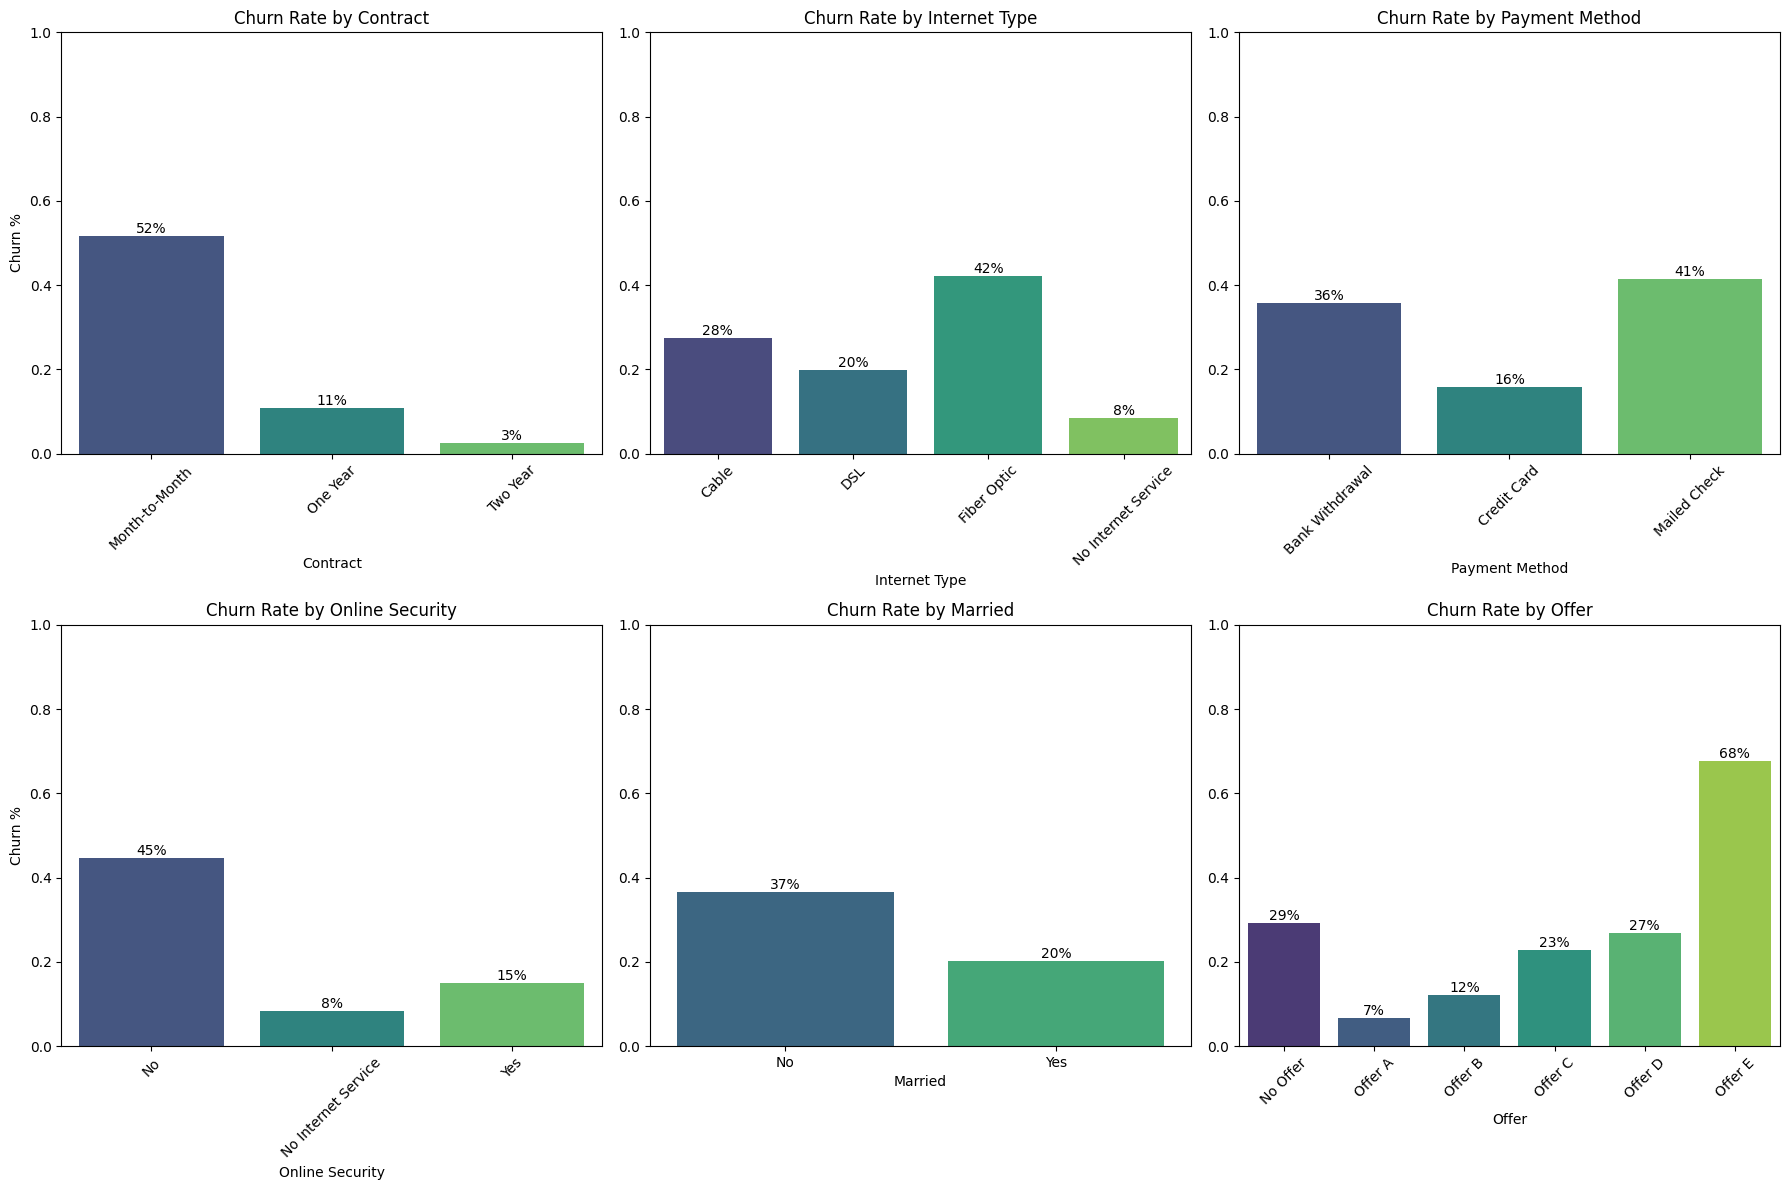

In [25]:
def plot_churn_grid(df, segments, figsize=(18, 12)):
    """Simplified grid of churn rate visualizations"""
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    plt.rcdefaults()  # Reset to default style

    for idx, seg in enumerate(segments):
        ax = axes.flat[idx]
        churn_rate = df.groupby(seg)['Customer Status'].mean().reset_index()

        # Create plot
        sns.barplot(x=seg, y='Customer Status', data=churn_rate, ax=ax, hue=seg,
                   palette='viridis', order=churn_rate[seg], legend=False)

        # Annotations and styling
        ax.set_title(f'Churn Rate by {seg}')
        ax.set_ylabel('Churn %' if idx%3==0 else '')
        ax.set_ylim(0, 1)

        # Rotate long labels
        if len(churn_rate) > 2:
            ax.tick_params(axis='x', rotation=45)

        # Add percentage labels
        for bar in ax.patches:
            ax.annotate(f'{bar.get_height():.0%}',
                       (bar.get_x() + bar.get_width()/2, bar.get_height()),
                       ha='center', va='bottom', fontsize=10)

    # Clean up empty plots
    for ax in axes.flat[len(segments):]:
        ax.remove()

    plt.tight_layout()
    return fig

# Usage
segments = ['Contract', 'Internet Type', 'Payment Method',
            'Online Security', 'Married', 'Offer']

plot_churn_grid(train_merged_df, segments)
plt.show()

Month to Month contracts comes with over 50% churn,

Fiber Optic as an Internet type comes with 42.7%,

Customers whom use Credit cards for payment are less to churn,

Having no Online Security makes Customers Churn easily,

Married Customers tends to churn  than singles by around 16%,

Offer E effect is unbelievable, it makes 68% of customers churn.


In [26]:
print(train_merged_df[train_merged_df['Offer'] == 'Offer A'].shape[0])
print(train_merged_df[train_merged_df['Offer'] == 'Offer E'].shape[0])


520
630


the feature Offer isn't biased

## Tenure Survival Analysis

Understand churn timing patterns

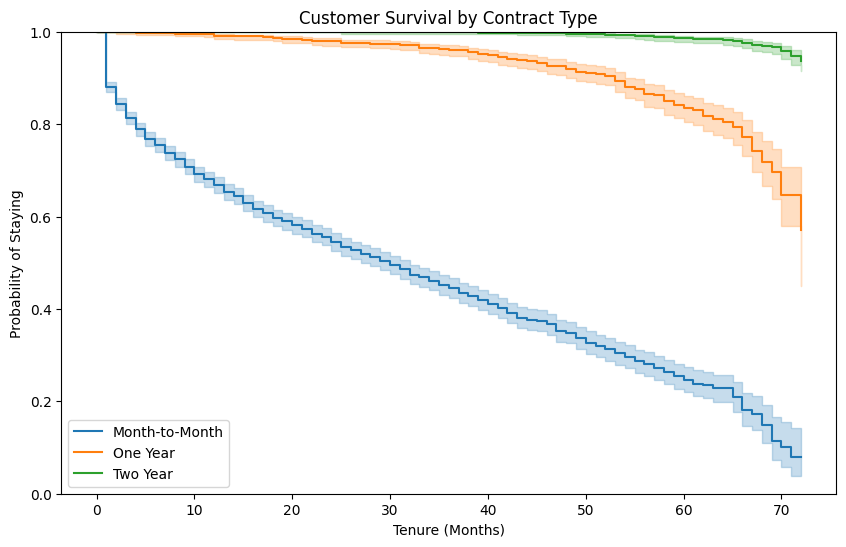

In [27]:
plt.figure(figsize=(10,6))

# Create plot for each contract type
for contract in ['Month-to-Month', 'One Year', 'Two Year']:
    mask = train_merged_df['Contract'] == contract
    kmf = KaplanMeierFitter()
    kmf.fit(train_merged_df[mask]['Tenure in Months'],
          event_observed=train_merged_df[mask]['Customer Status'])
    kmf.plot_survival_function(label=contract)

plt.title('Customer Survival by Contract Type')
plt.xlabel('Tenure (Months)')
plt.ylabel('Probability of Staying')
plt.ylim(0, 1)
plt.legend();

Month-to-Month: Customers with this contract are more likely to leave early on.

One Year/Two Year: Customers with these contracts are much more likely to stay longer.

<ipython-input-28-92639839e4eb>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_churn = train_merged_df.groupby('TenureBin')['Customer Status'].mean().reset_index()


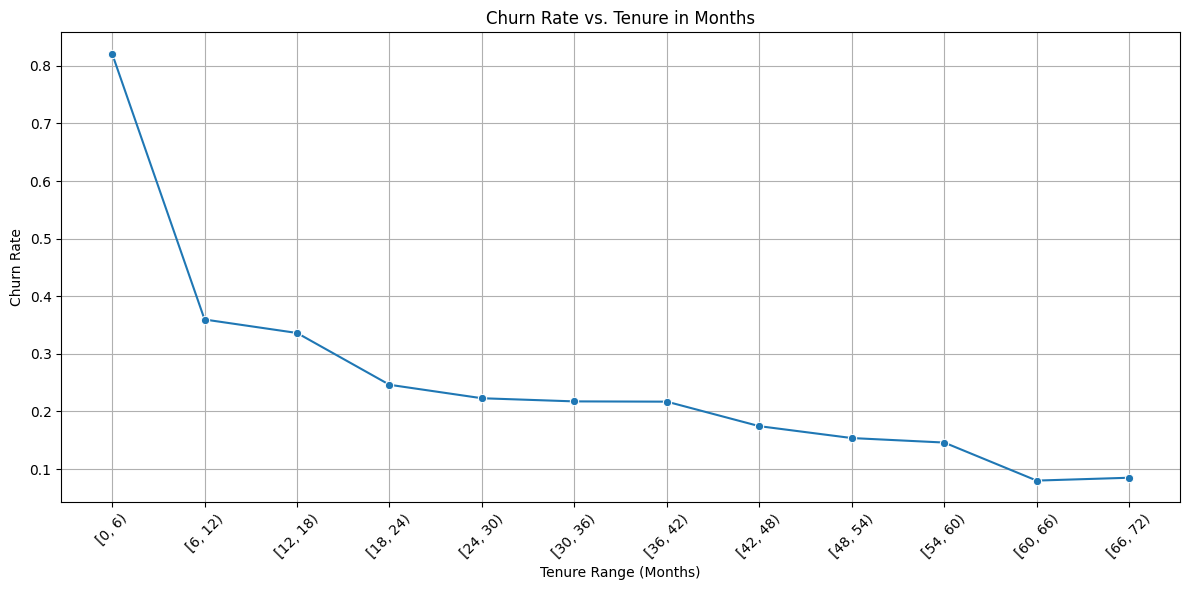

In [28]:
# Bin tenure into ranges (optional for smoother trends)
train_merged_df['TenureBin'] = pd.cut(train_merged_df['Tenure in Months'], bins=range(0, 75, 6), right=False)

# Group by tenure and calculate churn rate
tenure_churn = train_merged_df.groupby('TenureBin')['Customer Status'].mean().reset_index()

tenure_churn['TenureBin'] = tenure_churn['TenureBin'].astype(str) # Convert to string

# Plot churn rate over tenure bins
plt.figure(figsize=(12, 6))
sns.lineplot(x='TenureBin', y='Customer Status', data=tenure_churn, marker='o')
plt.xticks(rotation=45)
plt.title('Churn Rate vs. Tenure in Months')
plt.ylabel('Churn Rate')
plt.xlabel('Tenure Range (Months)')
plt.grid(True)
plt.tight_layout()
plt.show()

this proves our previous takeaways related to contract type

## Text Analysis on Churn Reason

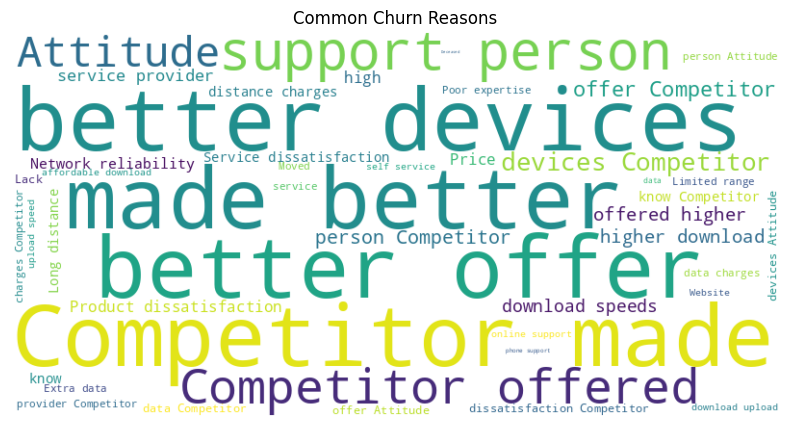

In [29]:
churned = train_merged_df[train_merged_df['Customer Status'] == 1]
text = ' '.join(churned['Churn Reason'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Churn Reasons')
plt.show()


## Service Bundle Analysis

let's have a look at the most and least effective bundles

In [30]:
def create_service_bundle(row):
    bundle = []
    bundle.append(f"Internet_{row['Internet Type']}")

    # Add service add-ons
    if row['Internet Service'] == 'Yes':
        bundle.append(f"Backup_{row['Online Backup']}")
        bundle.append(f"Security_{row['Online Security']}")
        bundle.append(f"Support_{row['Premium Tech Support']}")
        bundle.append(f"Protection_{row['Device Protection Plan']}")
        bundle.append(f"TV_{row['Streaming TV']}")
        bundle.append(f"Movies_{row['Streaming Movies']}")
        bundle.append(f"Music_{row['Streaming Music']}")

    return " + ".join(bundle)

train_merged_df['Service_Bundle'] = train_merged_df.apply(create_service_bundle, axis=1)

<ipython-input-31-b99966d34f0e>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Churn_Rate', y=bundles_to_plot.index,


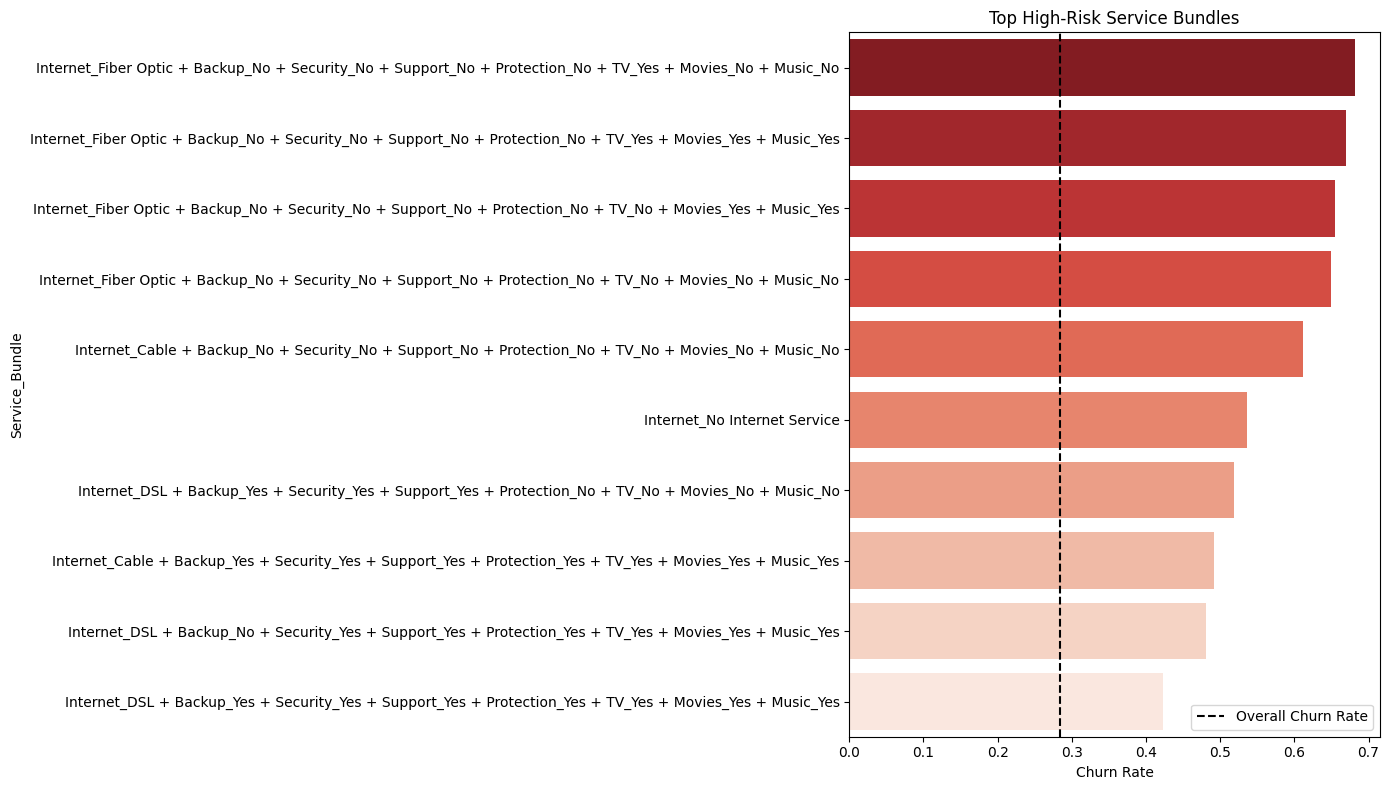

In [31]:
bundle_analysis = train_merged_df.groupby('Service_Bundle').agg(
    Total_Customers=('Customer ID', 'count'),
    Churn_Rate=('Customer Status', 'mean')
).sort_values('Churn_Rate', ascending=False)

# Filter meaningful bundles (min 50 customers)
significant_bundles = bundle_analysis[bundle_analysis['Total_Customers'] >= 50]

# Visualize top risky/protective bundles
plt.figure(figsize=(14, 8))

top_5_bundles = significant_bundles.head(5)
bottom_5_bundles = significant_bundles.tail(5)
bundles_to_plot = pd.concat([top_5_bundles, bottom_5_bundles])

sns.barplot(x='Churn_Rate', y=bundles_to_plot.index,
            data=significant_bundles.head(10),
            palette='Reds_r')

plt.title('Top High-Risk Service Bundles')
plt.xlabel('Churn Rate')
plt.axvline(train_merged_df['Customer Status'].mean(),
           color='black', linestyle='--',
           label='Overall Churn Rate')
plt.legend()
plt.tight_layout()

# Feature Engineering

## Service‐Bundle Indicators

add-ons

In [32]:
def add_on_features(df, addons):
    df['AddOnCount'] = df[addons].apply(lambda row: sum(row == 'Yes'), axis=1)
    return df

addons = [
    'Online Security', 'Online Backup',
    'Device Protection Plan', 'Premium Tech Support',
]

train_merged_df = add_on_features(train_merged_df, addons)

Check it's usefulness:

In [33]:
correlation_addon_churn = train_merged_df['AddOnCount'].corr(train_merged_df['Customer Status'])
print(f"Correlation between AddOnCount and Customer Status: {correlation_addon_churn}")


Correlation between AddOnCount and Customer Status: -0.2088869667792822


AddOnCount feature correlates with customer staying by 20%

 streams

In [34]:
def stream_features(df):
    df['StreamCount'] = df[['Streaming TV', 'Streaming Movies', 'Streaming Music']].apply(lambda row: sum(row == 'Yes'), axis=1)
    return df

train_merged_df = stream_features(train_merged_df)

## Tenure & Contract Features

In [35]:
def tenure_and_contract_engineering(df):
    # Continuous + bucketed tenure
    df['TenureMonths'] = df['Tenure in Months']
    df['TenureBins'] = pd.cut(
        df['TenureMonths'],
        bins=[0, 6, 12, 24, 36, 60, 100],
        labels=['0–6','6–12','12–24','24–36','36–60','60+']
    )
    # Contract encoded ordinally
    contract_map = {'Month-to-Month': 0, 'One Year': 1, 'Two Year': 2}
    df['ContractLen'] = df['Contract'].map(contract_map)
    return df

train_merged_df = tenure_and_contract_engineering(train_merged_df)



In [36]:
correlation_matrix = train_merged_df[['ContractLen','Customer Status']].corr(numeric_only=True)
correlation_matrix


,ContractLen,Customer Status
ContractLen,1.000000,-0.484365
Customer Status,-0.484365,1.000000


TenureBins will help our model understands nonlinearity and ContractLen Correlates very well with Customer Loyalty

## Monetary Value Features

High monthly charges but high total charges play opposing roles. Let’s capture per‐month intensity and lifetime value:

check for refunds:

check for extra charges:

In [37]:
def calculate_clv(df):
    """Calculate predictive CLV based on months remaining in the current contract cycle."""
    # Define contract durations
    contract_length_map = {
        'Month-to-Month': 1,
        'One Year': 12,
        'Two Year': 24
    }

    # Map to numerical contract lengths
    df['ContractLengthNum'] = df['Contract'].map(contract_length_map)

    # Calculate months remaining in current contract cycle
    df['RemainingMonths'] = df['ContractLengthNum'] - (df['Tenure in Months'] % df['ContractLengthNum'])

    # Month-to-month customers have no 'remaining' contract cycle
    df.loc[df['Contract'] == 'Month-to-month', 'RemainingMonths'] = 1

    # Final CLV prediction
    df['CLV'] = df['Monthly Charge'] * df['RemainingMonths']

    return df
def create_refund_flags(df):
  """Creates flags for refunds"""
  df['HadRefunds'] = (df['Total Refunds'] > 0).astype(int)
  return df

def extra_data_charge_flag(df):
    """Creates flags for extra data charges."""
    df['HadExtraDataCharges'] = (df['Total Extra Data Charges'] > 0).astype(int)
    return df

train_merged_df = calculate_clv(train_merged_df)
train_merged_df = create_refund_flags(train_merged_df)
train_merged_df = extra_data_charge_flag(train_merged_df)

In [38]:
# Calculate the correlation coefficient
correlation = train_merged_df['RemainingMonths'].corr(train_merged_df['Customer Status'])
print(f"Correlation coefficient between Remaining Months and Customer Status: {correlation}")

correlation = train_merged_df['CLV'].corr(train_merged_df['Customer Status'])
print(f"Correlation coefficient between CLV and Customer Status: {correlation}")

Correlation coefficient between Remaining Months and Customer Status: -0.34724320445338397
Correlation coefficient between CLV and Customer Status: -0.2503686845695078


## Zip-Code

check customer status based on its zipcode

In [ ]:
def cv_target_encode(df: pd.DataFrame,group_col: str,target_col: str,n_splits: int = 5,
    random_state: int = 42, suffix: str = '_CV') -> pd.DataFrame:
    """
    Perform cross-validated target mean encoding on `group_col` with respect to `target_col`.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.
    group_col : str
        The name of the categorical column to encode.
    target_col : str
        The binary target column name (e.g. 'Customer Status').
    n_splits : int, default=5
        Number of folds for KFold.
    random_state : int, default=42
        Random seed for shuffling.
    suffix : str, default='_CV'
        Suffix to append to `group_col` for the new encoded column.

    Returns
    -------
    pd.DataFrame
        The DataFrame with a new column: `<group_col><suffix>` containing the CV target means.
    """
    # Prepare output column
    new_col = f"{group_col}{suffix}"
    df[new_col] = np.nan

    # Global mean to fill unseen categories
    global_mean = df[target_col].mean()

    # Set up folds
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_pos, valid_pos in kf.split(df):
        # Convert positions to index labels
        train_idx = df.index[train_pos]
        valid_idx = df.index[valid_pos]

        # Compute mean target per category on the train split
        fold_means = (
            df.loc[train_idx]
              .groupby(group_col)[target_col]
              .mean()
        )

        # Map to the validation fold
        df.loc[valid_idx, new_col] = df.loc[valid_idx, group_col].map(fold_means)

    # Fill any missing (unseen categories) with global mean
    df[new_col].fillna(global_mean, inplace=True)

    return df

train_merged_df = cv_target_encode(train_merged_df, 'Zip Code', 'Customer Status')



<ipython-input-39-5a0f51f15d0d>:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[new_col].fillna(global_mean, inplace=True)


In [40]:
# Calculate the correlation coefficient
correlation = train_merged_df['Zip Code_CV'].corr(train_merged_df['Customer Status'])
print(f"Correlation coefficient between Zip Code Churn Rate and Customer Status: {correlation}")


Correlation coefficient between Zip Code Churn Rate and Customer Status: 0.12042446817995756


adding CV and skipping the Row on itself, gives us honest values of the effect of the Zip code on Customer Churn

# Pipeline and Modeling

## split the data

In [41]:
telecom_churn_df = telecom_churn_df[telecom_churn_df['Customer Status'] != 'Joined']
telecom_churn_df['Customer Status'] = telecom_churn_df['Customer Status'].apply(lambda x: 1 if x == 'Churned' else 0)
X = telecom_churn_df.drop(columns=['Customer Status'])
y = telecom_churn_df['Customer Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

<ipython-input-41-c3ce7dca2c28>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_churn_df['Customer Status'] = telecom_churn_df['Customer Status'].apply(lambda x: 1 if x == 'Churned' else 0)


## zip code mean transformer

we will build a hashmap that calculates churn rate per zip code and we will map the zip codes to their churn rate in the pipeline

In [42]:
train_enc = cv_target_encode(
    telecom_merged_df.copy(),
    group_col='Zip Code',
    target_col='Customer Status',
    n_splits=5,
    random_state=42,
    suffix='_CV'
)

# 2) Extract the mapping of ZIP → encoded churn rate
zip_cv_map = train_enc.set_index('Zip Code')['Zip Code_CV'].to_dict()

# 3) Compute the global mean for any unseen ZIPs
global_zip_mean = train_enc['Zip Code_CV'].mean()

def add_zip_cv(df):
    df = df.copy()
    df['ZipCode_CV'] = df['Zip Code'].map(zip_cv_map).fillna(global_zip_mean)
    return df

zip_cv_transformer = FunctionTransformer(add_zip_cv, validate=False)

<ipython-input-39-5a0f51f15d0d>:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[new_col].fillna(global_mean, inplace=True)


## Build pipeline

Wrap our fun. in functions transformers

In [43]:
def fill_offer_transformer(df):
    return fill_offer_na(df.copy())
fill_offer_tf = FunctionTransformer(fill_offer_transformer, validate=False)
#def fill_phone_transformer(df):
#   return fill_phone_service_depndents(df.copy())

#fill_phone_tf = FunctionTransformer(fill_phone_transformer, validate=False)
def fill_internet_transformer(df):
    return fill_internet_add_ons(df.copy())

fill_internet_tf = FunctionTransformer(fill_internet_transformer, validate=False)

def add_addons_transformer(df):
    return add_on_features(df.copy(), addons)

add_addons_tf = FunctionTransformer(add_addons_transformer, validate=False)

def tenure_engineering_transformer(df):
    return tenure_and_contract_engineering(df.copy())

tenure_eng_tf = FunctionTransformer(tenure_engineering_transformer, validate=False)

def calculate_clv_transformer(df):
    return calculate_clv(df.copy())

calc_clv_tf = FunctionTransformer(calculate_clv_transformer, validate=False)

def refund_flag_transformer(df):
    return create_refund_flags(df.copy())

refund_flag_tf = FunctionTransformer(refund_flag_transformer, validate=False)

def extra_data_flag_transformer(df):
    return extra_data_charge_flag(df.copy())

extra_flag_tf = FunctionTransformer(extra_data_flag_transformer, validate=False)

def stream_feats_transformer(df):
    return stream_features(df.copy())

stream_feats_tf = FunctionTransformer(stream_feats_transformer, validate=False)

def add_zip_cv_transformer(df):
    return add_zip_cv(df.copy())

zip_cv_tf = FunctionTransformer(add_zip_cv_transformer, validate=False)



pick features

In [44]:
num_feats = ['Age', 'Number of Dependents', 'Number of Referrals', 'Tenure in Months',
                 'Avg Monthly GB Download', 'Monthly Charge',
                 'Total Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges',
                 'Total Revenue', 'Zip Code']

skewed_feats = ['Number of Referrals', 'Avg Monthly GB Download', 'Total Charges',
                'Total Long Distance Charges','Total Revenue']

cat_feats = ['Married', 'Offer','Phone Service', 'Internet Type',
             'Online Security', 'Online Backup', 'Device Protection Plan',
             'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
             'Streaming Music', 'Contract', 'Paperless Billing',
             'Payment Method']

to_drop = ['Total Refunds', 'Total Extra Data Charges', 'Zip Code',  'Internet Service',
           'Online Security', 'Online Backup', 'Device Protection Plan',
             'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
             'Streaming Music']

ordinal_feats = ['Contract', 'Payment Method']
ohe_feats     = [c for c in cat_feats if c not in ordinal_feats + to_drop]
contract_categories = [['Month-to-Month', 'One Year', 'Two Year']]
payment_categories  = [['Mailed Check', 'Bank Withdrawal', 'Credit Card']]
ordinal_categories = contract_categories + payment_categories




In [45]:
def drop_raw_columns(df):
    return df.drop(columns=to_drop)

drop_raw = FunctionTransformer(drop_raw_columns, validate=False)

### Trees Pipeline

#### Decision Tree

In [46]:
# 1) Build the DecisionTree pipeline
dt_pipeline = ImbPipeline([
    ('impute_offer',    fill_offer_tf),
    ('impute_internet', fill_internet_tf),
    ('feature_eng_1',   add_addons_tf),
    ('feature_eng_2',   tenure_eng_tf),
    ('feature_eng_3',   calc_clv_tf),
    ('feature_eng_4',   refund_flag_tf),
    ('feature_eng_5',   extra_flag_tf),
    ('feature_eng_6',   stream_feats_tf),
    ('zip_cv',          zip_cv_tf),
    ('drop_raw',        drop_raw),
    ('encode', ColumnTransformer([
        ('ohe',     OneHotEncoder(handle_unknown='ignore', sparse_output=False), ohe_feats),
        ('ord',     OrdinalEncoder(categories=ordinal_categories), ordinal_feats),
        ('pass_num','passthrough', [c for c in num_feats if c not in to_drop])
    ], remainder='drop')),
    ('smote', SMOTE(random_state=42)),
    ('clf',   DecisionTreeClassifier(random_state=42))
])



In [47]:
# 2) Define the hyperparameter distribution
dt_param_dist = {
    # Depth of the tree
    'clf__max_depth': [None, 5, 10, 20, 30, 50],
    # Minimum samples required to split an internal node
    'clf__min_samples_split': [2, 5, 10, 20],
    # Minimum samples required to be at a leaf node
    'clf__min_samples_leaf': [1, 2, 4, 10],
    # Number of features to consider when looking for the best split
    'clf__max_features': ['sqrt', 'log2', None],
    # Criterion for splitting
    'clf__criterion': ['gini', 'entropy', 'log_loss']
}


In [245]:
# 3) Set up RandomizedSearchCV
dt_random_search = RandomizedSearchCV(
    estimator   = dt_pipeline,
    param_distributions = dt_param_dist,
    n_iter      = 30,            # try 30 random combinations
    cv          = 5,             # 5-fold CV
    scoring     = {'accuracy': 'accuracy', 'recall': 'recall'},
    refit       = 'accuracy',
    n_jobs      = -1,
    random_state= 42,
    verbose     = 2
)
# fit on data
dt_random_search.fit(X_train, y_train)

# 5) Inspect best results
print("Best DT Params:", dt_random_search.best_params_)
print("Best DT Recall:", dt_random_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best DT Params: {'clf__min_samples_split': 5, 'clf__min_samples_leaf': 4, 'clf__max_features': None, 'clf__max_depth': 10, 'clf__criterion': 'gini'}
Best DT Recall: 0.8556284791855895


In [246]:
dt_random_search.score(X_test, y_test)

0.8376327769347496

In [247]:
# Predict on the test set using the best estimator
y_pred = dt_random_search.best_estimator_.predict(X_test)
y_prob = dt_random_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)
roc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F2 Score: {f2}")
print(f"ROC AUC: {roc}")

Accuracy: 0.8376327769347496
Recall: 0.7058823529411765
Precision: 0.717391304347826
F2 Score: 0.7081545064377682
ROC AUC: 0.8798646673615518


save and download the best dt

In [248]:
joblib.dump(dt_random_search.best_estimator_, '/content/dt_best_estimator_.joblib')

# Download the saved file
files.download('/content/dt_best_estimator_.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### RandomForest

In [191]:
# tree_preprocessor = Pipeline([
#     ('impute_offer',    fill_offer_tf),
#     ('impute_internet', fill_internet_tf),
#     ('feature_eng_1',   add_addons_tf),
#     ('feature_eng_2',   tenure_eng_tf),
#     ('feature_eng_3',   calc_clv_tf),
#     ('feature_eng_4',   refund_flag_tf),
#     ('feature_eng_5',   extra_flag_tf),
#     ('feature_eng_6',   stream_feats_tf),
#     ('zip_cv',          zip_cv_tf),
#     ('drop_raw', FunctionTransformer(lambda df: df.drop(columns=to_drop), validate=False)),
#     ('encode', ColumnTransformer([
#         ('ohe',     OneHotEncoder(handle_unknown='ignore', sparse_output=False), ohe_feats),
#         ('ord',     OrdinalEncoder(categories=ordinal_categories), ordinal_feats),
#         ('pass_num', 'passthrough', [c for c in num_feats if c not in to_drop])
#     ], remainder='drop'))
# ])

Param Grid for RF

In [249]:
param_dist = {
    'clf__n_estimators': [100, 200, 300, 400, 500],
    'clf__max_depth': [None, 10, 20, 30, 40, 50],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': [None, 'sqrt', 'log2'],
    'clf__bootstrap': [True, False]
}

RF pipeline

In [250]:
rf_pipeline = ImbPipeline([
    ('impute_offer',    fill_offer_tf),
    ('impute_internet', fill_internet_tf),
    ('feature_eng_1',   add_addons_tf),
    ('feature_eng_2',   tenure_eng_tf),
    ('feature_eng_3',   calc_clv_tf),
    ('feature_eng_4',   refund_flag_tf),
    ('feature_eng_5',   extra_flag_tf),
    ('feature_eng_6',   stream_feats_tf),
    ('zip_cv',          zip_cv_tf),
    ('drop_raw', drop_raw),
    ('encode', ColumnTransformer([
        ('ohe',     OneHotEncoder(handle_unknown='ignore', sparse_output=False), ohe_feats),
        ('ord',     OrdinalEncoder(categories=ordinal_categories), ordinal_feats),
        ('pass_num', 'passthrough', [c for c in num_feats if c not in to_drop])
    ], remainder='drop')),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

Run RandomizedSearchCV

In [251]:
rf_random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist,
    n_iter=30,              # try 30 random combinations
    cv=5,                   # 5-fold cross-validation
    verbose=2,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# fit the model
rf_random_search.fit(X_train, y_train)

#Best model and score
print("Best Parameters:", rf_random_search.best_params_)
print("Best CV Score:", rf_random_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'clf__n_estimators': 100, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 4, 'clf__max_features': 'sqrt', 'clf__max_depth': 20, 'clf__bootstrap': False}
Best CV Score: 0.8742169303128682


In [252]:
rf_random_search.best_estimator_.score(X_test, y_test)

0.8581183611532626

In [253]:
# Predict on the test set using the best estimator
y_pred = rf_random_search.best_estimator_.predict(X_test)
y_prob = rf_random_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)
roc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F2 Score: {f2}")
print(f"ROC AUC: {roc}")


Accuracy: 0.8581183611532626
Recall: 0.6711229946524064
Precision: 0.7968253968253968
F2 Score: 0.6929872998343457
ROC AUC: 0.9177920783105229


safe and download best rf

In [254]:
joblib.dump(rf_random_search.best_estimator_, '/content/rf_best_estimator_.joblib')

# Download the saved file
files.download('/content/rf_best_estimator_.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Non Trees Pipeline

#### Logistic Regression

In [56]:
def log1p_transform(X):
    return np.log1p(X)

logistic_pipeline = ImbPipeline([
    ('impute_offer',     fill_offer_tf),
    ('impute_internet',  fill_internet_tf),
    ('feature_eng_1',    add_addons_tf),
    ('feature_eng_2',    tenure_eng_tf),
    ('feature_eng_3',    calc_clv_tf),
    ('feature_eng_4',    refund_flag_tf),
    ('feature_eng_5',    extra_flag_tf),
    ('feature_eng_6',    stream_feats_tf),
    ('zip_cv',           zip_cv_tf),
    ('drop_raw',         drop_raw),
    ('encode_and_scale', ColumnTransformer([
        # a) Skewed numeric: log1p then StandardScaler
        ('skewed', Pipeline([
            ('log1p', FunctionTransformer(log1p_transform, validate=False)),
            ('scale', StandardScaler())
        ]), skewed_feats),

        # b) Other numeric: just scale
        ('num', StandardScaler(),
            [c for c in num_feats if c not in skewed_feats + to_drop]),

        # c) Nominal categoricals: one-hot
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ohe_feats),

        # d) Ordinal categoricals
        ('ord', OrdinalEncoder(categories=ordinal_categories), ordinal_feats),
    ], remainder='drop')),

    #  Balance with SMOTE
    #('smote', SMOTE(random_state=42)),

    # Polynomial features
    ('poly', PolynomialFeatures(include_bias=False)),

    # 14) Logistic regression
    ('clf', LogisticRegression(random_state=42))
])

param dist

In [57]:
param_dist = {

   'poly__degree': [1, 2, 3],

    # Inverse regularization strength: smaller C => stronger regularization
    'clf__C': np.logspace(-3, 2, 20),

    # Try both L1 and L2 penalties
    'clf__penalty': ['l1', 'l2'],

    # Solver must support your penalties
    'clf__solver': ['liblinear', 'saga'],

    # Optionally tweak max_iter if convergence issues arise
    'clf__max_iter': [100, 200, 500],

}

RandomizedSearch

In [58]:
logistic_search = RandomizedSearchCV(
    estimator=logistic_pipeline,
    param_distributions=param_dist,
    n_iter=30,             # try 40 random combos
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

#Fit the data
logistic_search.fit(X_train, y_train)

# 5) Inspect best results
print("Best parameters:", logistic_search.best_params_)
print("Best CV score :", logistic_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'poly__degree': 3, 'clf__solver': 'saga', 'clf__penalty': 'l2', 'clf__max_iter': 500, 'clf__C': np.float64(0.12742749857031335)}
Best CV score : 0.8744052447458115


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


evaluations

In [59]:
# Predict on the test set using the best estimator
y_pred = logistic_search.best_estimator_.predict(X_test)
y_prob = logistic_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)
roc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F2 Score: {f2}")
print(f"ROC AUC: {roc}")


Accuracy: 0.8520485584218513
Recall: 0.6657754010695187
Precision: 0.780564263322884
F2 Score: 0.6859504132231405
ROC AUC: 0.9182509290310887


In [60]:
joblib.dump(logistic_search.best_estimator_, '/content/logistic_search_best_estimator_.joblib')

# Download the saved file
files.download('/content/logistic_search_best_estimator_.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>